<a href="https://colab.research.google.com/github/DButmeh/Chicago-Crime-Data/blob/main/Chicago_Crime_Data._Part_2ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chicago Crime Data
###**Dina Al Botmeh**
-------------------------------------------------
---------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
# set random seed
SEED = 321
np.random.seed(SEED)
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)



<a name='new0'></a>
# ⭐️ **load data /:crimes in Chicago**
>[Click here](#new1) to jump to assignment's solution.


# ⭐️ **Topic 1) THEFT:the crime count forecast**
>[Click here](#new3) to jump to assignment's solution.

# ⭐️**Topic 2)BATTERY:the crime count forecast**
>[Click here](#new7) to jump to assignment's solution.


# ⭐️**comparing between crime count forecas THEFT V BATTERY**
>[Click here](#new5) to jump to assignment's solution.

# ⭐️**Topic 3) Total Crime  count forecast :**
>[Click here](#new6) to jump to assignment's solution.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import glob
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
import pytz
import seaborn as sns
import statsmodels.tsa.api as tsa
!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
# set random seed
SEED = 321
np.random.seed(SEED)



In [ ]:
!pip install pmdarima
import pmdarima as pm


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)



In [ ]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax



In [ ]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics


In [ ]:
def get_sig_lags(ts, type='ACF',  nlags=None,alpha=0.5):


    if type == 'ACF':
        # Running the function used by plot_acf
        corr_values, conf_int = tsa.stattools.acf(ts, alpha=alpha, nlags=nlags)

    elif type=='PACF':
        corr_values, conf_int = tsa.stattools.pacf(ts, alpha=alpha, nlags=nlags)

    else:
        raise Exception("type must be either 'ACF' or 'PACF'")

    # Determine lags
    lags =range(len(corr_values))

    # Create a centered version of the acf_df
    corr_df = pd.DataFrame({type:corr_values,
                            'Lags':lags,
                            'lower ci': conf_int[:,0]-corr_values, # subtract acf from lower ci to center
                            'upper ci': conf_int[:,1]-corr_values, # subtact acf to upper ci to center
                                 })
    corr_df = corr_df.set_index("Lags")

    # Getting filter for sig lags
    filter_sig_lags = (corr_df[type] < corr_df['lower ci']) | (corr_df[type] > corr_df['upper ci'])

    # Get lag #'s
    sig_lags= corr_df.index[filter_sig_lags]
    sig_lags = sig_lags[sig_lags!=0]

    return sig_lags



In [ ]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)


    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)




    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig



In [ ]:
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)


In [ ]:
# Set options
pd.set_option('display.max_columns',100)
# Customize figure style for stakeholder-facing visualizations
plt.style.use(('ggplot','fivethirtyeight'))
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.5



In [ ]:
def format_xdates2(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_yearm = mdates.YearLocator()
    fmt_yearm = mdates.DateFormatter("%Y")
    ## for major year ticks
    loc_year = mdates.YearLocator(5)
    fmt_year = mdates.DateFormatter("%Y")

    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),
                       fontweight=xtick_fontweight)

    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_yearm)
    ax.xaxis.set_minor_formatter(fmt_yearm)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax



In [ ]:
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major
    ticks every year. Includes different grid options for visibility"""
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")

    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),
                       fontweight=xtick_fontweight)

    ## customize major ticks xaxis
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')

    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax



<a name='new1'></a>
# ⭐️**Load the data:**
>[Click here](#new0) to jump to up .

In [ ]:
P = "/content/drive/MyDrive/week14 study/newalldata.csv"
df = pd.read_csv(P).drop(columns="Unnamed: 0")
df.head()


,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 603.2+ MB


In [ ]:
#Change the column name to be a clear indicator
df = df.rename(columns={'Primary Type': 'Crime Type'})

In [ ]:
df.isna().sum()

,0
ID,0
Date,0
Crime Type,0
Description,0
Location Description,10928
Arrest,0
Domestic,0
Beat,0
District,47
Ward,614846


In [ ]:
# Convert the 'Date' column to datetime if it's not already
## Converting crimedatetime and coercing errors
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
## setting and sorting the index
df = df.set_index("Date")
df = df.sort_index()
df.head(3)

,ID,Crime Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01,3214584,THEFT,FINANCIAL ID THEFT: OVER $300,STREET,False,False,2221,22.0,21.0,41.732563,-87.669923
2001-01-01,1927872,THEFT,AGG: FINANCIAL ID THEFT,RESIDENCE,False,False,812,8.0,NaN,41.778094,-87.770137
2001-01-01,4768442,OFFENSE INVOLVING CHILDREN,SEX ASSLT OF CHILD BY FAM MBR,RESIDENCE,False,False,2124,2.0,4.0,41.807275,-87.593707


 <a name='new3'></a>
# ⭐️**Topic 1) THEFT:the crime count forecast**
>[Click here](#new0) to jump to up .

In [ ]:
ts_1 = df[df["Crime Type"] == "THEFT"].resample('MS').size()
ts_1.name = "'THEFT'"
print(f"NUN Value = {ts_1.isna().sum()}")
print(ts_1.index)
ts_1.head(2)

NUN Value = 0
DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='Date', length=264, freq='MS')


,'THEFT'
Date,
2001-01-01,7867
2001-02-01,6669


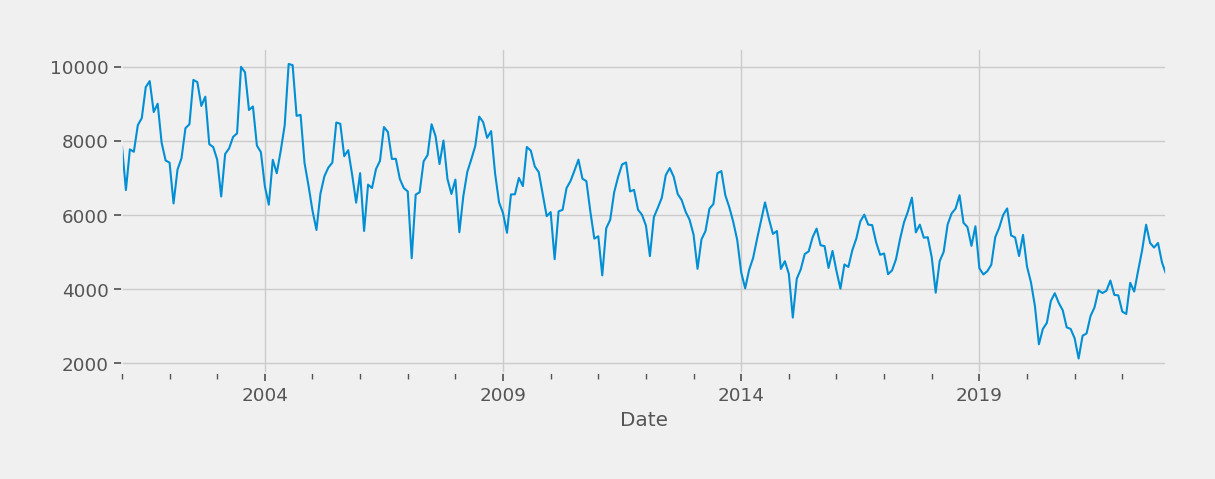

In [ ]:
# Visualize selected time series
ax = ts_1.plot()

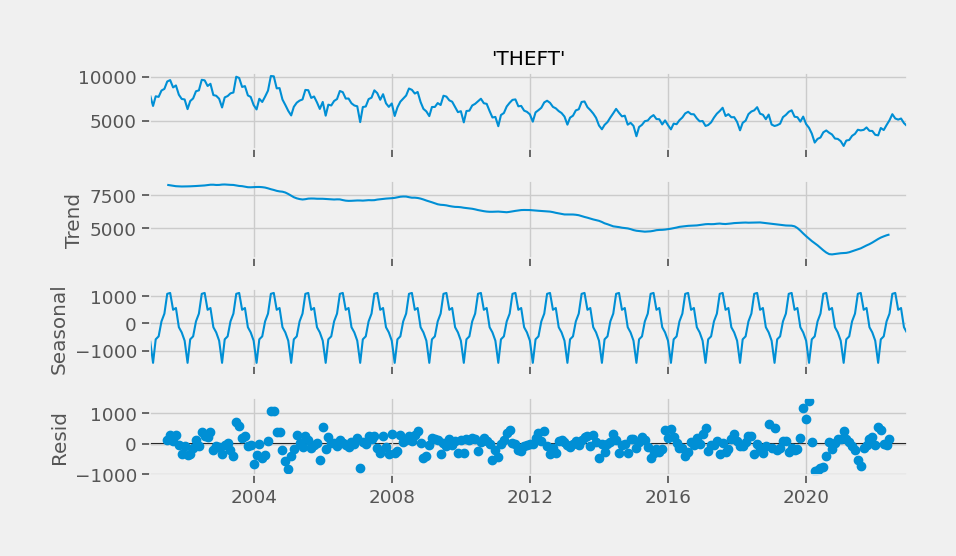

In [ ]:
## Use Seasonal Decompose to check for seasonality
decomp = tsa.seasonal_decompose(ts_1)
fig = decomp.plot()
fig.set_size_inches(9, 5)
fig.tight_layout()

In [ ]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts_1.max()-ts_1.min()) * 100 :.2f}% of the variation in time series.")


The seasonal component is 2549.988095238095 which is ~32.08% of the variation in time series.


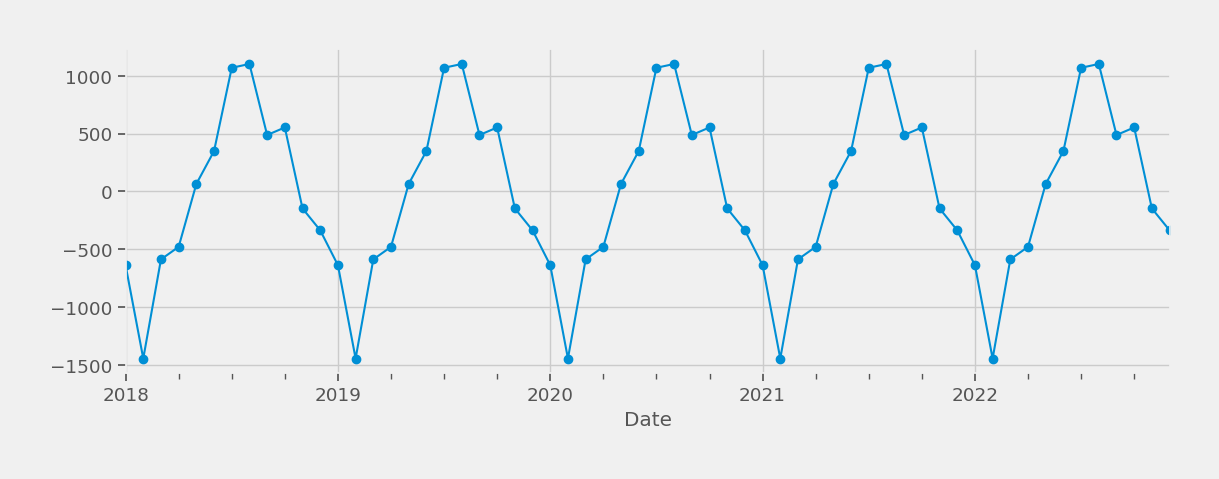

In [ ]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2018': '2022'].plot(marker = 'o')

In [ ]:
# Check for stationarity
get_adfuller_results(ts_1)


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.393935,13,250,0.58518,0.05,False


In [ ]:
ts1_diff = ts_1.diff().dropna()
get_adfuller_results(ts1_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.953728,12,250,0.001673,0.05,True


In [ ]:
# Determine differencing
d = ndiffs(ts_1)
print(f'd is {d}')
D = nsdiffs(ts_1, m =12)
print(f'D is {D}')



d is 1
D is 0


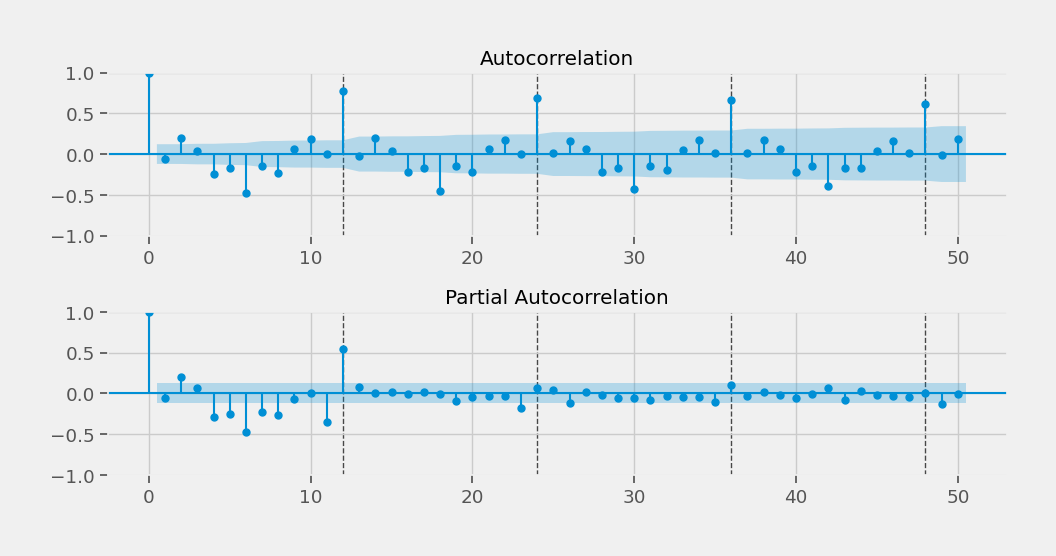

In [ ]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts1_diff, annotate_seas = True, m = 12, nlags = 50);

# p and q
- It appears that both the ACF and PACF gradually decrease in magnitude.
- starting with AR(1) and MA(1).
#P and Q
-The seasonal lags in the PACF show a drop off  after snlag 1, and the seasonal lags in the ACF stay consistently high.
- The SPACF plot above shows a very abrupt drop after lag 1. This indicates that we only need one coefficient in our SAR model, known as a seasonal-AR(1) model  , and a seasonal-MA, SMA(0).
# The pbqPBQ=
(1,1,1,1,0,0)

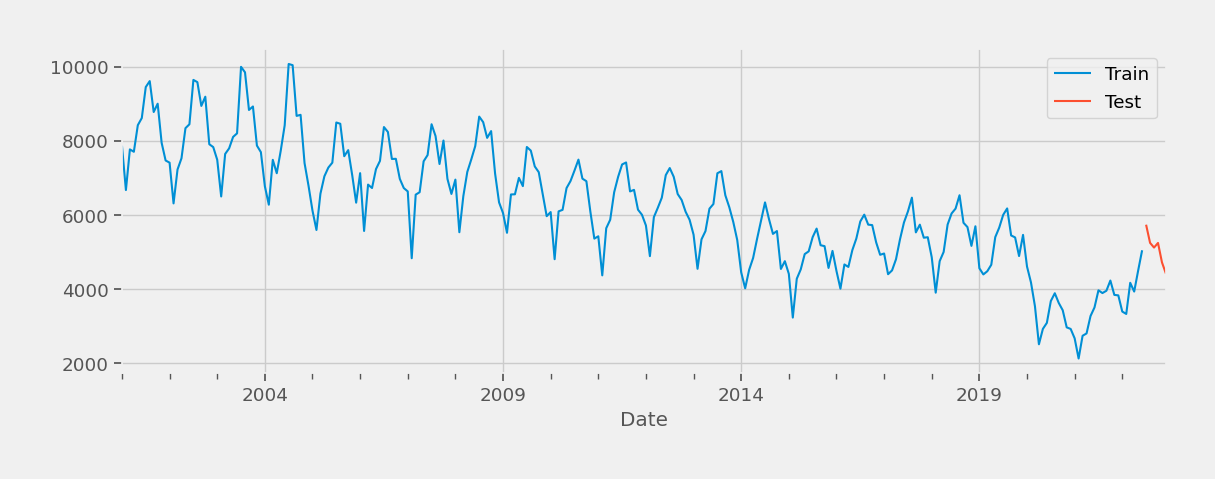

In [ ]:
train, test = train_test_split(ts_1, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [ ]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           'THEFT'   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1897.686
Date:                           Thu, 19 Sep 2024   AIC                           3803.371
Time:                                   11:53:50   BIC                           3817.567
Sample:                               01-01-2001   HQIC                          3809.080
                                    - 06-01-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9640      0.171     -5.636      0.000      -1.299      -0.629
ma.L1          0.9701      0.155      6.267      0.000       0.667       1.274
ar.S.L12       0.7794      0.029     26.848      0.000       0.722       0.836
sigma2      1.376e+05   1.04e+04     13.255      0.000    1.17e+05    1.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   9.32   Jarque-Bera (JB):                 4.44
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               0.72   Skew:                            -0.07
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 424.992
- MSE = 243,329.318
- RMSE = 493.284
- R^2 = -0.379
- MAPE = 8.77%


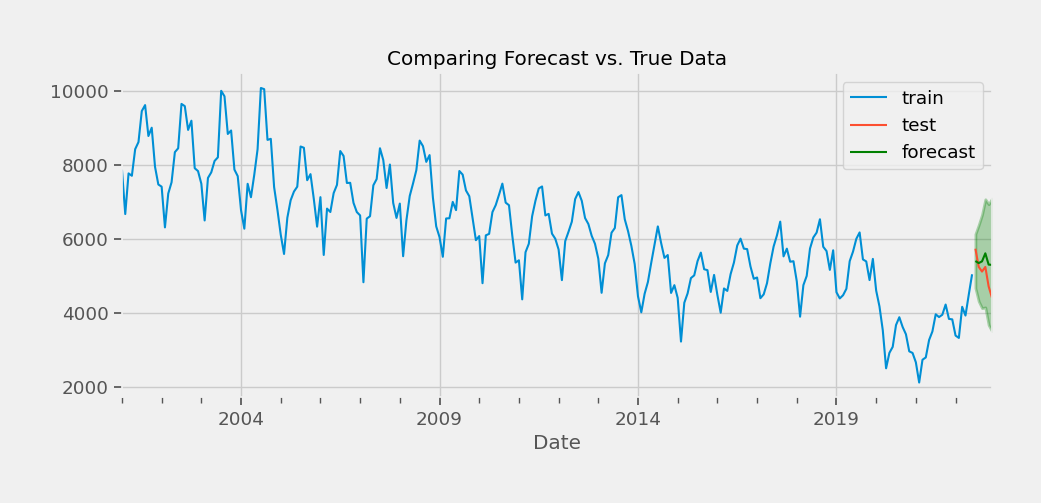

In [ ]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

# MAPE = 8.7% is larger than 1%
-   A negative R-squared suggests that the ARIMA model may not be capturing the underlying patterns in your time series data effectively. It could be that the chosen model order (pdqPDQm) is inappropriate for your data
#Loop through variations looking for better model

In [ ]:
import itertools
# Define the value or range of values for p, d, q
p_values = range(0, 5)
d_values = [1]
q_values = range(0, 5)
P_values = range (0, 5)
D_values = [0]
Q_values = range (0,5)
m = [12]
# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))
# Display first 10 combinations
pdqPDQm_to_try[:10]



[(0, 1, 0, 0, 0, 0, 12),
 (0, 1, 0, 0, 0, 1, 12),
 (0, 1, 0, 0, 0, 2, 12),
 (0, 1, 0, 0, 0, 3, 12),
 (0, 1, 0, 0, 0, 4, 12),
 (0, 1, 0, 1, 0, 0, 12),
 (0, 1, 0, 1, 0, 1, 12),
 (0, 1, 0, 1, 0, 2, 12),
 (0, 1, 0, 1, 0, 3, 12),
 (0, 1, 0, 1, 0, 4, 12)]

In [ ]:
#from joblib import Parallel, delayed, Memory
#from statsmodels.tsa.statespace.sarimax import SARIMAX

##cache_dir = 'cachedir'
##memory = Memory(cache_dir, verbose=0)

#best_aic = float("inf")
#best_pdqPDQm = None

#@memory.cache
#def fit_arima(pdqPDQm, train):
#  """
 #   Fits an ARIMA model for given pdqPDQm parameters.
 # Returns the parameters and the AIC score.
  #  """
    #order = pdqPDQm[:3]
   # seasonal_order = pdqPDQm[3:]

   # try:
       # model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
       # result = model.fit(disp=False)

     #   return pdqPDQm, result.aic
   # except Exception as e:
      #  print(f'{pdqPDQm}: caused an error - {e}')
      #  return pdqPDQm, float("inf")

#results = Parallel(n_jobs=-1)(delayed(fit_arima)(pdqPDQm, train) for pdqPDQm in pdqPDQm_to_try)

#best_pdqPDQm, best_aic = min(results, key=lambda x: x[1])

##print("Best AIC:", best_aic)
#print("Best pdqPDQm:", best_pdqPDQm)



In [ ]:
# define starting aic as infinity
best_aic = float("inf")
# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)
# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)

    model = tsa.ARIMA(train, order=order, seasonal_order = seasonal_order)
    try:
        result = model.fit()
        print(pdqPDQm, result.aic)

    except:
        print(f'{pdqPDQm}: caused an error')

    # If lower, replace best AIC with new value
    if result.aic < best_aic:

        best_aic = result.aic
        best_pdqPDQm = pdqPDQm
# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)



(0, 1, 0, 0, 0, 0, 12) 4048.6031252628172
(0, 1, 0, 0, 0, 1, 12) 3914.385057208162
(0, 1, 0, 0, 0, 2, 12) 3873.3968538010895
(0, 1, 0, 0, 0, 3, 12) 3842.1177428836745
(0, 1, 0, 1, 0, 0, 12) 3799.555094196551
(0, 1, 0, 1, 0, 1, 12) 3754.67630323483
(0, 1, 0, 1, 0, 2, 12) 3753.3872956566997
(0, 1, 0, 1, 0, 3, 12) 3751.156024652456
(0, 1, 0, 2, 0, 0, 12) 3783.137795166216
(0, 1, 0, 2, 0, 1, 12) 3754.3928798723746
(0, 1, 0, 2, 0, 2, 12) 3753.6210410293843
(0, 1, 0, 2, 0, 3, 12) 3750.2043335309136
(0, 1, 0, 3, 0, 0, 12) 3763.6387019660474
(0, 1, 0, 3, 0, 1, 12) 3751.4352833064504
(0, 1, 0, 3, 0, 2, 12) 3749.021071404117


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 0, 3, 0, 3, 12) 3752.207024344373
(0, 1, 1, 0, 0, 0, 12) 4049.3931393516045
(0, 1, 1, 0, 0, 1, 12) 3912.7285944758655
(0, 1, 1, 0, 0, 2, 12) 3869.893484340309
(0, 1, 1, 0, 0, 3, 12) 3837.2226499866943
(0, 1, 1, 1, 0, 0, 12) 3790.0720980034353
(0, 1, 1, 1, 0, 1, 12) 3742.534852097084
(0, 1, 1, 1, 0, 2, 12) 3765.666149518259
(0, 1, 1, 1, 0, 3, 12) 3738.0495328318048
(0, 1, 1, 2, 0, 0, 12) 3772.9047887857487


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 1, 2, 0, 1, 12) 3742.3193888852347


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 1, 2, 0, 2, 12) 2149.748983710254
(0, 1, 1, 2, 0, 3, 12) 3788.0909251833377
(0, 1, 1, 3, 0, 0, 12) 3751.8077647968144


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 1, 3, 0, 1, 12) 3758.3053367425323
(0, 1, 1, 3, 0, 2, 12): caused an error
(0, 1, 1, 3, 0, 3, 12) 3815.1208428217533
(0, 1, 2, 0, 0, 0, 12) 4029.752197474269
(0, 1, 2, 0, 0, 1, 12) 3906.521084000439
(0, 1, 2, 0, 0, 2, 12) 3866.6196441239
(0, 1, 2, 0, 0, 3, 12) 3834.900912300106
(0, 1, 2, 1, 0, 0, 12) 3791.8666979352975
(0, 1, 2, 1, 0, 1, 12) 3744.4479605386705
(0, 1, 2, 1, 0, 2, 12) 3743.2319986138045


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 1, 0, 3, 12) 3740.905061914691
(0, 1, 2, 2, 0, 0, 12) 3774.5047552508004
(0, 1, 2, 2, 0, 1, 12): caused an error
(0, 1, 2, 2, 0, 2, 12) 3774.7433112673034


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 2, 0, 3, 12) 3775.3980093483824
(0, 1, 2, 3, 0, 0, 12) 3753.7951851148932


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 3, 0, 1, 12) 3759.968181797621
(0, 1, 2, 3, 0, 2, 12): caused an error
(0, 1, 2, 3, 0, 3, 12): caused an error
(0, 1, 3, 0, 0, 0, 12) 4022.114947644941
(0, 1, 3, 0, 0, 1, 12) 3904.0640456698775
(0, 1, 3, 0, 0, 2, 12) 3868.398716660439
(0, 1, 3, 0, 0, 3, 12) 3836.9009049935466
(0, 1, 3, 1, 0, 0, 12) 3792.8297261767702
(0, 1, 3, 1, 0, 1, 12) 3744.5175695790863
(0, 1, 3, 1, 0, 2, 12) 3743.701307449879
(0, 1, 3, 1, 0, 3, 12) 3767.2807838761514
(0, 1, 3, 2, 0, 0, 12) 3774.6220183671576
(0, 1, 3, 2, 0, 1, 12) 3760.8150755287193
(0, 1, 3, 2, 0, 2, 12) 3784.824244440019
(0, 1, 3, 2, 0, 3, 12) 3794.038701793692
(0, 1, 3, 3, 0, 0, 12) 3754.5380274151894


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 3, 3, 0, 1, 12) 3761.2122606810426
(0, 1, 3, 3, 0, 2, 12): caused an error
(0, 1, 3, 3, 0, 3, 12) 3875.409143436871
(1, 1, 0, 0, 0, 0, 12) 4048.874560853245
(1, 1, 0, 0, 0, 1, 12) 3911.818899296486
(1, 1, 0, 0, 0, 2, 12) 3868.7670296148103
(1, 1, 0, 0, 0, 3, 12) 3835.923372176624
(1, 1, 0, 1, 0, 0, 12) 3789.747142341851
(1, 1, 0, 1, 0, 1, 12) 3742.3067543240286
(1, 1, 0, 1, 0, 2, 12) 3741.2675595586784
(1, 1, 0, 1, 0, 3, 12) 3738.527952066479
(1, 1, 0, 2, 0, 0, 12) 3772.2306838339664


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0, 2, 0, 1, 12) 3770.9442797866336
(1, 1, 0, 2, 0, 2, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0, 2, 0, 3, 12) 3776.0412393602305
(1, 1, 0, 3, 0, 0, 12) 3751.92529157645
(1, 1, 0, 3, 0, 1, 12) 3757.371639931289


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0, 3, 0, 2, 12) 3764.038373486309
(1, 1, 0, 3, 0, 3, 12) 3855.7514096840578
(1, 1, 1, 0, 0, 0, 12) 4048.1312514248184
(1, 1, 1, 0, 0, 1, 12) 3915.759719935627
(1, 1, 1, 0, 0, 2, 12) 3869.661805106204


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 0, 0, 3, 12) 3845.1345397121495
(1, 1, 1, 1, 0, 0, 12) 3803.3711788171927
(1, 1, 1, 1, 0, 1, 12) 3758.809191680122


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 1, 0, 2, 12) 3757.0827578296276


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 1, 0, 3, 12) 3739.877628087157


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 2, 0, 0, 12) 3787.0750243196017
(1, 1, 1, 2, 0, 1, 12) 3789.187449945089


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 2, 0, 2, 12) 3749.1253274428063


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 2, 0, 3, 12) 3798.618251072663


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 3, 0, 0, 12) 3767.395789510796


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 3, 0, 1, 12) 3754.556564366154
(1, 1, 1, 3, 0, 2, 12): caused an error
(1, 1, 1, 3, 0, 3, 12) 3816.1638402450562
(1, 1, 2, 0, 0, 0, 12) 4026.8700008084575
(1, 1, 2, 0, 0, 1, 12) 3916.6686423939427
(1, 1, 2, 0, 0, 2, 12) 3868.5630814034707
(1, 1, 2, 0, 0, 3, 12) 3836.900911173733
(1, 1, 2, 1, 0, 0, 12) 3794.07281814007
(1, 1, 2, 1, 0, 1, 12): caused an error
(1, 1, 2, 1, 0, 2, 12) 14.0
(1, 1, 2, 1, 0, 3, 12) 3749.467613511726
(1, 1, 2, 2, 0, 0, 12) 3776.9339163224868
(1, 1, 2, 2, 0, 1, 12) 3746.343517759733
(1, 1, 2, 2, 0, 2, 12) 3789.752412413737
(1, 1, 2, 2, 0, 3, 12) 3799.743455287482
(1, 1, 2, 3, 0, 0, 12) 3755.8070084036976


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 3, 0, 1, 12) 3743.2625359545254
(1, 1, 2, 3, 0, 2, 12): caused an error
(1, 1, 2, 3, 0, 3, 12): caused an error
(1, 1, 3, 0, 0, 0, 12) 4010.506159160352
(1, 1, 3, 0, 0, 1, 12) 3887.2690967339804
(1, 1, 3, 0, 0, 2, 12) 3857.288864979965


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3, 0, 0, 3, 12) 3825.7455382299513
(1, 1, 3, 1, 0, 0, 12) 3795.7788061534748
(1, 1, 3, 1, 0, 1, 12) 3785.659532949966
(1, 1, 3, 1, 0, 2, 12) 3812.8834179009973
(1, 1, 3, 1, 0, 3, 12) 3781.369165406439
(1, 1, 3, 2, 0, 0, 12) 3779.068409384675
(1, 1, 3, 2, 0, 1, 12): caused an error
(1, 1, 3, 2, 0, 2, 12): caused an error
(1, 1, 3, 2, 0, 3, 12) 3799.9821930412563


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3, 3, 0, 0, 12) 3759.0581751607638
(1, 1, 3, 3, 0, 1, 12) 3755.61756257425
(1, 1, 3, 3, 0, 2, 12) 3833.25478740315
(1, 1, 3, 3, 0, 3, 12) 3861.717445051512
(2, 1, 0, 0, 0, 0, 12) 4038.208593492386
(2, 1, 0, 0, 0, 1, 12) 3910.2727788560537
(2, 1, 0, 0, 0, 2, 12) 3868.4420791511593
(2, 1, 0, 0, 0, 3, 12) 3836.05196367929
(2, 1, 0, 1, 0, 0, 12) 3791.7470733555147
(2, 1, 0, 1, 0, 1, 12) 3744.2995280234836


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 0, 1, 0, 2, 12) 3743.206175449812
(2, 1, 0, 1, 0, 3, 12) 3766.060423633718
(2, 1, 0, 2, 0, 0, 12) 3774.1606309585163
(2, 1, 0, 2, 0, 1, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 0, 2, 0, 2, 12) 3797.61728360852


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 0, 2, 0, 3, 12) 3769.497908800535
(2, 1, 0, 3, 0, 0, 12) 3753.826291652562
(2, 1, 0, 3, 0, 1, 12) 3778.1936855476583
(2, 1, 0, 3, 0, 2, 12) 3763.1524810761757
(2, 1, 0, 3, 0, 3, 12) 18.0
(2, 1, 1, 0, 0, 0, 12) 4039.864503166485
(2, 1, 1, 0, 0, 1, 12) 3915.3782724478774
(2, 1, 1, 0, 0, 2, 12) 3870.340004224966
(2, 1, 1, 0, 0, 3, 12) 3839.592334124386
(2, 1, 1, 1, 0, 0, 12) 3793.7411794235945
(2, 1, 1, 1, 0, 1, 12) 3745.2004514020246


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 1, 0, 2, 12) 3744.498920794599
(2, 1, 1, 1, 0, 3, 12) 3863.0929083288124
(2, 1, 1, 2, 0, 0, 12) 3776.227363414635
(2, 1, 1, 2, 0, 1, 12) 3760.8526773225813
(2, 1, 1, 2, 0, 2, 12): caused an error
(2, 1, 1, 2, 0, 3, 12) 3815.2484603353396
(2, 1, 1, 3, 0, 0, 12) 3754.935311551484
(2, 1, 1, 3, 0, 1, 12): caused an error
(2, 1, 1, 3, 0, 2, 12): caused an error
(2, 1, 1, 3, 0, 3, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 0, 0, 0, 12) 4017.7045799189445


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(2, 1, 2, 0, 0, 1, 12) 3890.9074147474253


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 0, 0, 2, 12) 3880.4132896208384


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 3, 12) 3838.357827096326


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 1, 0, 0, 12) 3807.6223421867726


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(2, 1, 2, 1, 0, 1, 12) 14.0


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 1, 0, 2, 12) 3812.390919051575
(2, 1, 2, 1, 0, 3, 12) 3835.404801077858


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(2, 1, 2, 2, 0, 0, 12) 3778.656747130669
(2, 1, 2, 2, 0, 1, 12) 3804.937180056695


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 2, 0, 2, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 3, 12) 3836.5658987703964


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 3, 0, 0, 12) 3772.317903221616


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 3, 0, 1, 12): caused an error
(2, 1, 2, 3, 0, 2, 12): caused an error
(2, 1, 2, 3, 0, 3, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 0, 0, 0, 12) 3905.530961306454


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 0, 0, 1, 12) 3869.5544397460935


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 0, 0, 2, 12) 3865.901633063242


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 0, 0, 3, 12) 3859.568329974551


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 1, 0, 0, 12) 14.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 1, 0, 1, 12) 16.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 1, 0, 2, 12) 3796.631984926192


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 1, 0, 3, 12) 3829.7260896789376


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 2, 0, 0, 12) 3780.201816553892


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 2, 0, 1, 12) 3843.420515683374


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 2, 0, 2, 12) 3799.568113887436


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 2, 0, 3, 12): caused an error
(2, 1, 3, 3, 0, 0, 12) 3763.129687463074


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 3, 0, 1, 12): caused an error
(2, 1, 3, 3, 0, 2, 12) 3788.215501500542


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 3, 0, 3, 12) 3845.594329086547
(3, 1, 0, 0, 0, 0, 12) 4038.9155789120414
(3, 1, 0, 0, 0, 1, 12) 3910.726793065516
(3, 1, 0, 0, 0, 2, 12) 3869.9815104336694
(3, 1, 0, 0, 0, 3, 12) 3837.8797831125653
(3, 1, 0, 1, 0, 0, 12) 3793.7313935713964
(3, 1, 0, 1, 0, 1, 12) 3745.9487146441065


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 0, 1, 0, 2, 12) 3745.8746612582663
(3, 1, 0, 1, 0, 3, 12) 3741.9780873377804
(3, 1, 0, 2, 0, 0, 12) 3775.953087567037
(3, 1, 0, 2, 0, 1, 12) 3761.585780893014
(3, 1, 0, 2, 0, 2, 12) 3845.2517762493994


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 0, 2, 0, 3, 12) 3771.291200505761
(3, 1, 0, 3, 0, 0, 12) 3755.628022128416


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 0, 3, 0, 1, 12) 3761.759859272457


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 0, 3, 0, 2, 12) 3765.403384978024
(3, 1, 0, 3, 0, 3, 12): caused an error
(3, 1, 1, 0, 0, 0, 12) 4033.128905694936


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 0, 0, 1, 12) 3913.3435150865553
(3, 1, 1, 0, 0, 2, 12) 3872.4567920474874
(3, 1, 1, 0, 0, 3, 12) 3840.0552404480077
(3, 1, 1, 1, 0, 0, 12) 3795.779804628591
(3, 1, 1, 1, 0, 1, 12): caused an error
(3, 1, 1, 1, 0, 2, 12) 3831.194119282505
(3, 1, 1, 1, 0, 3, 12): caused an error
(3, 1, 1, 2, 0, 0, 12): caused an error
(3, 1, 1, 2, 0, 1, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 2, 0, 2, 12) 3842.593187053442
(3, 1, 1, 2, 0, 3, 12): caused an error
(3, 1, 1, 3, 0, 0, 12) 3758.231840362874


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 3, 0, 1, 12) 3754.8797072929246
(3, 1, 1, 3, 0, 2, 12): caused an error
(3, 1, 1, 3, 0, 3, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(3, 1, 2, 0, 0, 0, 12) 3928.06133073246


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 0, 0, 1, 12) 3895.0502123660176


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 0, 0, 2, 12) 3888.9541217397827


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 0, 0, 3, 12) 3832.8550586112297


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 1, 0, 0, 12) 3825.5453093214714


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(3, 1, 2, 1, 0, 1, 12) 3785.216104199652
(3, 1, 2, 1, 0, 2, 12) 3837.86785599493


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 1, 0, 3, 12) 3796.795199726359


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 2, 0, 0, 12) 3797.9682178438343


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(3, 1, 2, 2, 0, 1, 12) 3834.158735011224


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 2, 0, 2, 12) 3750.279502075676


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 2, 0, 3, 12) 3816.4515157754377


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 3, 0, 0, 12) 3757.7639200275185


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 3, 0, 1, 12) 3830.6597059183946


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 3, 0, 2, 12) 3812.7938998845066


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 3, 0, 3, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3, 0, 0, 0, 12) 3904.897862682648


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3, 0, 0, 1, 12) 3872.7528620633852


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 0, 0, 2, 12) 3866.9114121006


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 0, 0, 3, 12) 3837.594772577449


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3, 1, 0, 0, 12): caused an error
(3, 1, 3, 1, 0, 1, 12): caused an error
(3, 1, 3, 1, 0, 2, 12) 20.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 1, 0, 3, 12) 3830.484751169246


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3, 2, 0, 0, 12) 3789.540866438687


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3, 2, 0, 1, 12) 3776.4980704665218


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 2, 0, 2, 12) 3818.980244698175


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3, 2, 0, 3, 12): caused an error
(3, 1, 3, 3, 0, 0, 12): caused an error
(3, 1, 3, 3, 0, 1, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 3, 0, 2, 12) 3836.969647654817


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 3, 0, 3, 12) 3845.076554618554
Best AIC: 14.0
Best pdqPDQm: (1, 1, 2, 1, 0, 2, 12)


# the best pdqPDQm from Loop through variations
- pdqPDQm =(0,1,2,1,0,1,12)


In [ ]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1# nonseasonal differencing
q = 2 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 2 # Seasonal MA
m = 12 # Seasonal period

sarima1= tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          'THEFT'   No. Observations:                  258
Model:             ARIMA(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood                   0.000
Date:                          Thu, 19 Sep 2024   AIC                             14.000
Time:                                  12:47:16   BIC                             38.844
Sample:                              01-01-2001   HQIC                            23.991
                                   - 06-01-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000   5.39e-09  -1.86e+08      0.000      -1.000      -1.000
ma.L1          0.0064         -0       -inf      0.000       0.006       0.006
ma.L2         -0.9936         -0        inf      0.000      -0.994      -0.994
ar.S.L12       1.0000   4.97e-08   2.01e+07      0.000       1.000       1.000
ma.S.L12      -0.0060         -0        inf      0.000      -0.006      -0.006
ma.S.L24      -0.9940         -0        inf      0.000      -0.994      -0.994
sigma2        3.4e+08         -0       -inf      0.000     3.4e+08     3.4e+08
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

almost the same
-  Normal Q-Q Plot  the points  strlitly sround the line  the residuals are not normally distributed, which can affect the validity of the model's predictions.
- There are significant lags in the correlogram of residuals-it indicates our model has missed something.
- Standardized Residuals Over Time is not constant  there is a variance( magnitude of a peak befor 2004)

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 5,077.833
- MSE = 25,960,867.167
- RMSE = 5,095.181
- R^2 = -146.107
- MAPE = 100.00%


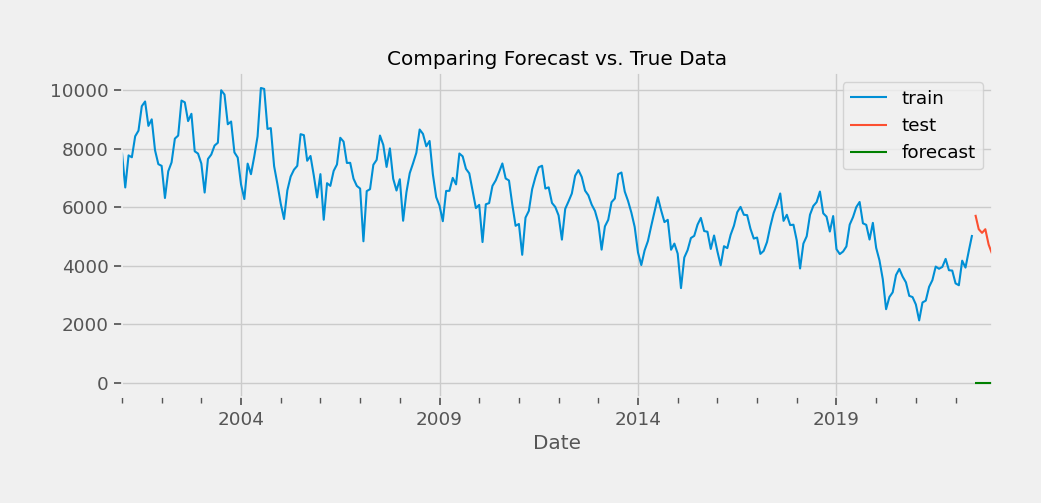

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df1 = sarima1.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df1);
# Obtain metrics
regression_metrics_ts(test, forecast_df1['mean'])

#This model is worst than the first model
- R2 is negtive
- MAPE is larger = 6.9% and is was 5.3%
- slightly improvment in AIC = 4513.55


#**Auto_Arima**

In [ ]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True
)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4050.524, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3791.710, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3914.631, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4048.603, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4050.805, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3774.214, Time=1.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3743.853, Time=6.59 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3743.960, Time=1.08 sec


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,0)(2,0,2)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 705, in fit
    mlefit = super().fit(start_params, method=method,
  File "/usr/local/lib/python3.10/dist-packa

 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3742.900, Time=2.68 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3870.719, Time=1.09 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3913.736, Time=0.40 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3754.859, Time=2.42 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=3745.608, Time=6.57 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.30 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3742.926, Time=2.77 sec
 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=8.23 sec
 ARIMA(1,1,0)(1,0,2)[12]             : AIC=3741.268, Time=1.45 sec
 ARIMA(1,1,0)(0,0,2)[12]             : AIC=3868.767, Time=0.96 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=3742.307, Time=0.77 sec


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,0)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 705, in fit
    mlefit = super().fit(start_params, method=method,
  File "/usr/local/lib/python3.10/dist-packa

 ARIMA(1,1,0)(2,0,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=3911.819, Time=0.29 sec
 ARIMA(1,1,0)(2,0,1)[12]             : AIC=inf, Time=3.42 sec
 ARIMA(0,1,0)(1,0,2)[12]             : AIC=3753.387, Time=1.09 sec
 ARIMA(2,1,0)(1,0,2)[12]             : AIC=3743.206, Time=7.73 sec
 ARIMA(1,1,1)(1,0,2)[12]             : AIC=inf, Time=3.63 sec
 ARIMA(0,1,1)(1,0,2)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(2,1,1)(1,0,2)[12]             : AIC=inf, Time=5.52 sec

Best model:  ARIMA(1,1,0)(1,0,2)[12]          
Total fit time: 71.316 seconds


# the best( pdqPDQm )from Auto_Arima
pdqPDQm = (1,1,0,1,0,2,12)

In [ ]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1# nonseasonal differencing
q = 0 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 2 # Seasonal MA
m = 12 # Seasonal period

sarima2= tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                               'THEFT'   No. Observations:                  258
Model:             ARIMA(1, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -1865.634
Date:                               Thu, 19 Sep 2024   AIC                           3741.268
Time:                                       12:49:20   BIC                           3759.013
Sample:                                   01-01-2001   HQIC                          3748.404
                                        - 06-01-2022                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2251      0.046     -4.934      0.000      -0.315      -0.136
ar.S.L12       0.9778      0.008    120.049      0.000       0.962       0.994
ma.S.L12      -0.5771      0.059     -9.814      0.000      -0.692      -0.462
ma.S.L24      -0.1202      0.068     -1.758      0.079      -0.254       0.014
sigma2      1.038e+05   7353.367     14.120      0.000    8.94e+04    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                30.54
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.44
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

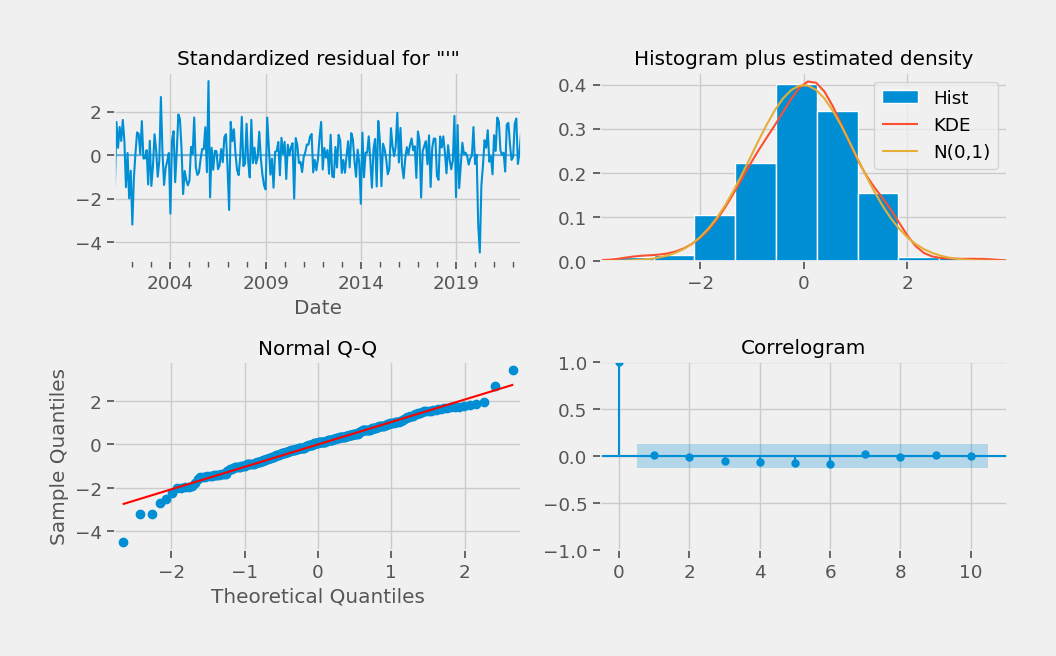

In [ ]:
# Obtain diagnostic plots
fig = sarima2.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()


- In the Normal Q-Q Plot, the points are on the line,
- There is no significant lag in the correlogram of residuals,
- The standardized residuals over time are not constant; there is notable variance, particularly with larger peaks .

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.160
- MSE = 72,805.923
- RMSE = 269.826
- R^2 = 0.587
- MAPE = 4.27%


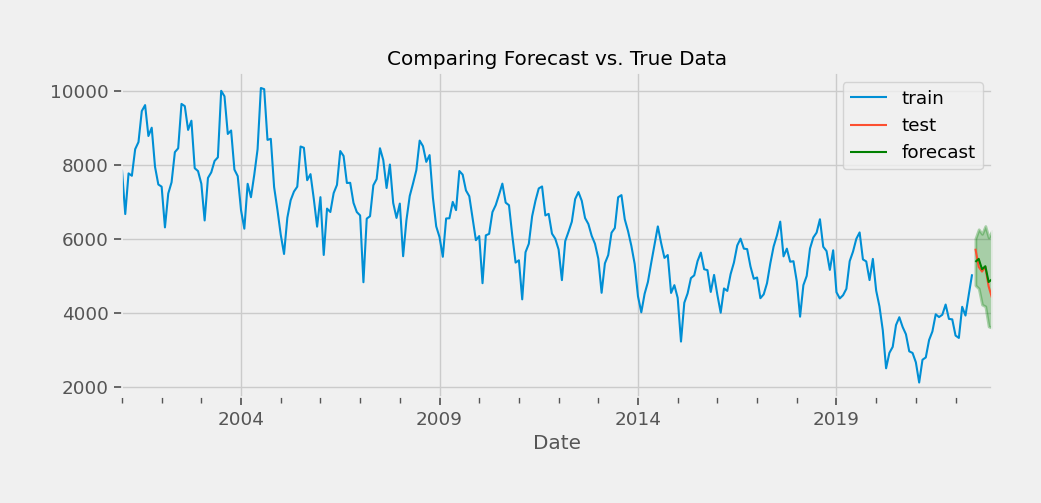

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df2 = sarima2.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df2);
# Obtain metrics
regression_metrics_ts(test, forecast_df2['mean'])

#This model is getting  worst than the two befor
- R2 isnot negtive
- MAPE is less = 4.27%
- slightly improvment in AIC = 3741


In [ ]:
print("\n","\033[1mComparing models with the same d value\033[0m")
print(f"sarima order {(sarima.model.order,sarima.model.seasonal_order)} {regression_metrics_ts(test, forecast_df['mean'])}")
print(f"sarima AIC = {sarima.aic.round(2)},\n ")

print(f"sarima1 order {(sarima1.model.order,sarima1.model.seasonal_order)} {regression_metrics_ts(test, forecast_df1['mean'])}")
print(f"sarima1 AIC = {sarima1.aic.round(2)},\n ")

print(f"sarima2 order {(sarima2.model.order,sarima2.model.seasonal_order)} {regression_metrics_ts(test, forecast_df2['mean'])}")
print(f"sarima2 AIC = {sarima2.aic.round(2)},\n ")


 Comparing models with the same d value
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 424.992
- MSE = 243,329.318
- RMSE = 493.284
- R^2 = -0.379
- MAPE = 8.77%
sarima order ((1, 1, 1), (1, 0, 0, 12)) None
sarima AIC = 3803.37,
 
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 5,077.833
- MSE = 25,960,867.167
- RMSE = 5,095.181
- R^2 = -146.107
- MAPE = 100.00%
sarima1 order ((1, 1, 2), (1, 0, 2, 12)) None
sarima1 AIC = 14.0,
 
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.160
- MSE = 72,805.923
- RMSE = 269.826
- R^2 = 0.587
- MAPE = 4.27%
sarima2 order ((1, 1, 0), (1, 0, 2, 12)) None
sarima2 AIC = 3741.27,
 


# The thired model is the best   MAPE= 4.24%  but the AIC = 3741.27

#Make true future forecasts using the entire dataset (for dates beyond the entire ts).

In [ ]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1# nonseasonal differencing
q = 0 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 2 # Seasonal MA
m = 12 # Seasonal period

final_model2= tsa.ARIMA(ts_1, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


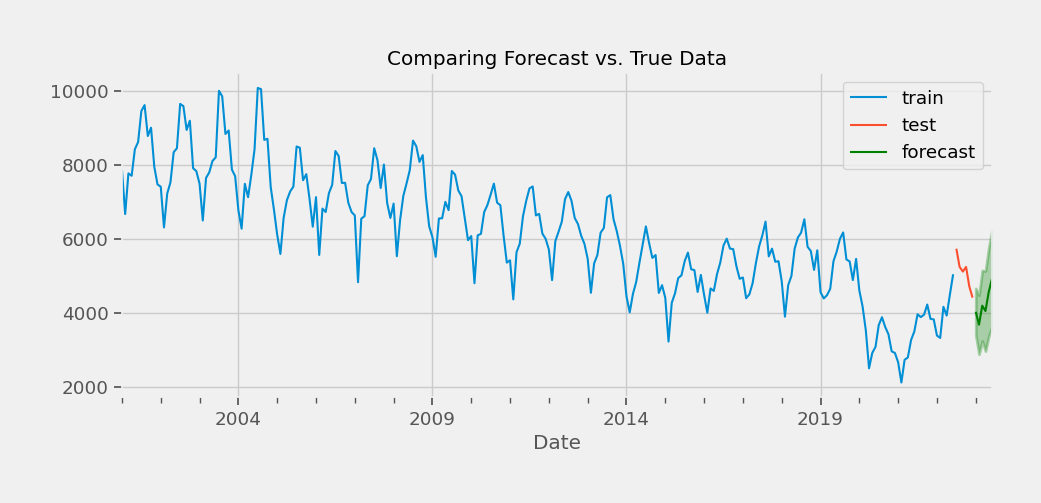

In [ ]:
# Obtain future forecasts beyond test data
forecast_df2  = final_model2.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df2);

In [ ]:
starting_value = forecast_df2['mean'].iloc[0]
starting_value

4031.376577072557

In [ ]:
# the predicted for 6 months into the future
final_value = forecast_df2['mean'].iloc[-1]
final_value


4920.784934797009

In [ ]:
change = final_value - starting_value
change

889.4083577244514

In [ ]:
#calculate this as a percentage by dividing the delta by the starting value.
perc_change = (change / starting_value) * 100
perc_change



22.06215025365624

In [ ]:
print(f'The allocated period is from {forecast_df2.index[0].strftime("%Y-%m-%d")} to {forecast_df2.index[-1].strftime("%Y-%m-%d")}.\n')
print(f"The total crime count over the 6 months is {forecast_df2['mean'].sum().round(2)} crimes.\n")
print(f"The percent change in crime count at the end of the 6 months is an increase of {perc_change.round(2)}%")

The allocated period is from 2023-01-01 to 2023-06-01.

The total crime count over the 6 months is 25446.98 crimes.

The percent change in crime count at the end of the 6 months is an increase of 22.06%


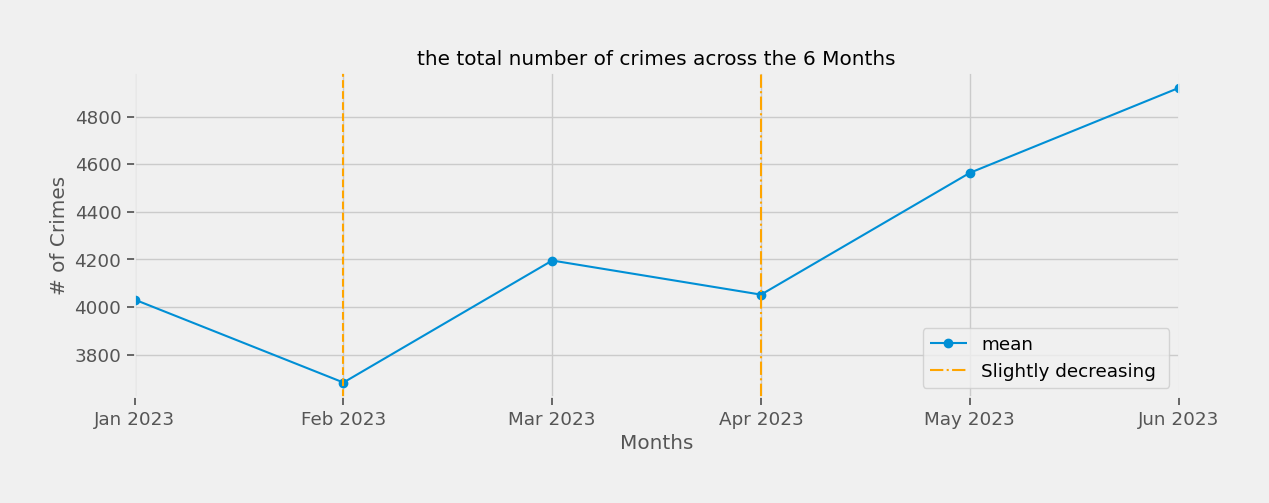

In [ ]:
ax=forecast_df2['mean'].plot(style='o-',grid=True,ylabel='# of Crimes', xlabel='Months',title="the total number of crimes across the 6 Months",
                    figsize=(12,4),xticks=forecast_df['mean'].index);
ax.set_xticklabels( [x.strftime('%b %Y') for x in forecast_df['mean'].index], rotation=0)
ax.axvline('2023-02-01', color='orange',ls='--')
ax.axvline('2023-04', color='orange',ls='-.',label='Slightly decreasing ')
ax.legend()
fig.tight_layout()
ax.set_xlim(['2023-01','2023-06'])
fig.savefig('SavedPlot.png', dpi = 300)


In [ ]:
forecast_dfts1=forecast_df2

 <a name='new7'></a>
# ⭐️**Topic 2) BATTERY:the crime count forecast**
>[Click here](#new0) to jump to up

In [ ]:
# Select Battery and then resample
ts_2 = df[df["Crime Type"]=='BATTERY'].resample('MS').size()
ts_2.name = "'BATTERY'" # Assign the name to the Series
print(f"NUN Value = {ts_2.isna().sum()}")
print(ts_2.index)
ts_2.head(2)

NUN Value = 0
DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='Date', length=264, freq='MS')


,'BATTERY'
Date,
2001-01-01,6527
2001-02-01,6042


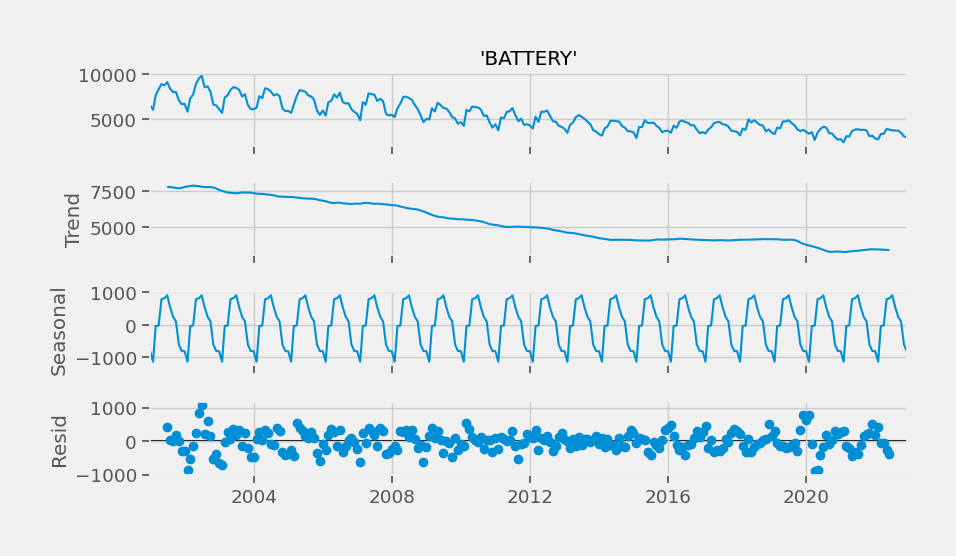

In [ ]:
## Use Seasonal Decompose to check for seasonality
decomp = tsa.seasonal_decompose(ts_2)
fig = decomp.plot()
fig.set_size_inches(9, 5)
fig.tight_layout()

In [ ]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts_2.max()-ts_2.min()) * 100 :.2f}% of the variation in time series.")


The seasonal component is 2040.1289682539682 which is ~27.70% of the variation in time series.


#the seaonal compont BATTERY =27% which less than THEFT seaonal compont=32%

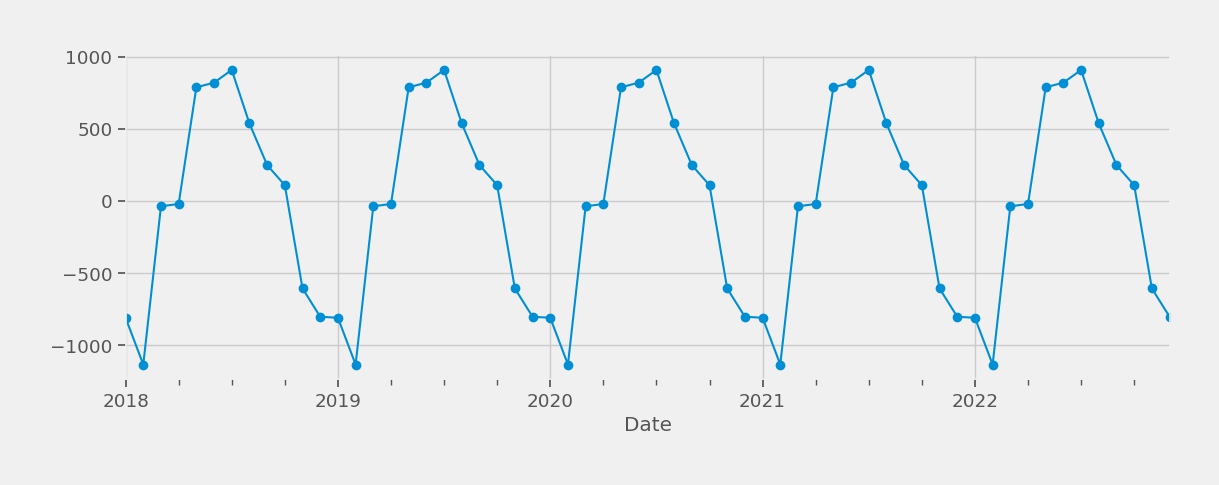

In [ ]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2018':].plot(marker = 'o')

In [ ]:
# Check for stationarity
get_adfuller_results(ts_2)


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.036843,15,248,0.739591,0.05,False


In [ ]:
ts2_diff = ts_2.diff().dropna()
get_adfuller_results(ts2_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-4.373363,14,248,0.000331,0.05,True


In [ ]:
# Determine differencing
d = ndiffs(ts_2)
print(f'd is {d}')
D = nsdiffs(ts_2, m =12)
print(f'D is {D}')



d is 1
D is 0


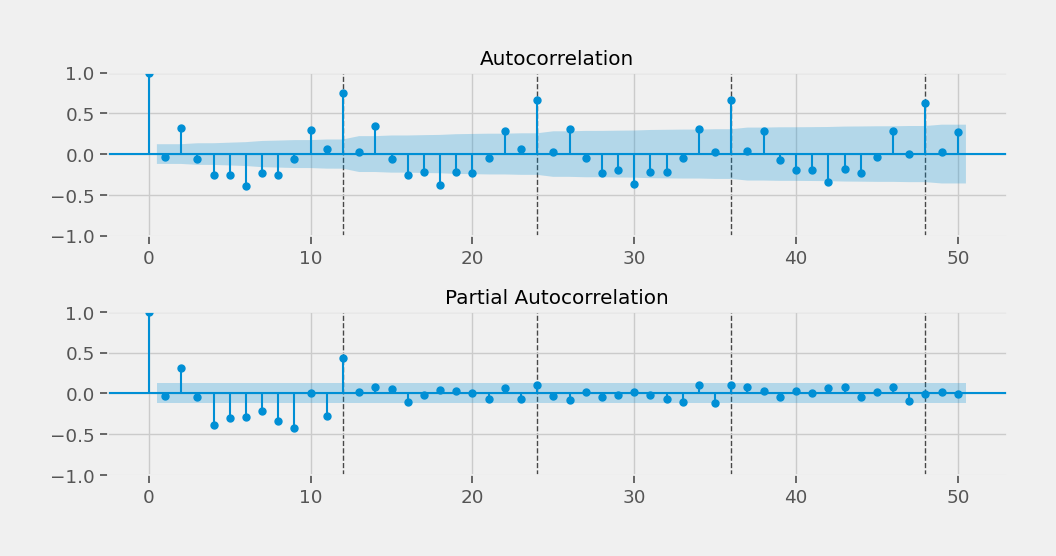

In [ ]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts2_diff, annotate_seas = True, m = 12, nlags = 50);

# the behaver of the data almost the same because thats was the conclogen that most of the craimes were decreasing .

# p and q
- It appears that both the ACF and PACF gradually decrease in magnitude.
- starting with AR(1) and MA(1).
#P and Q
-The seasonal lags in the PACF show a drop off  after snlag 1, and the seasonal lags in the ACF stay consistently high.
- The SPACF plot above shows a very abrupt drop after lag 1. This indicates that we only need one coefficient in our SAR model, known as a seasonal-AR(1) model  , and a seasonal-MA, SMA(0).
# The pbqPBQ=
(1,1,1,1,0,0)

#**Train Test Split**

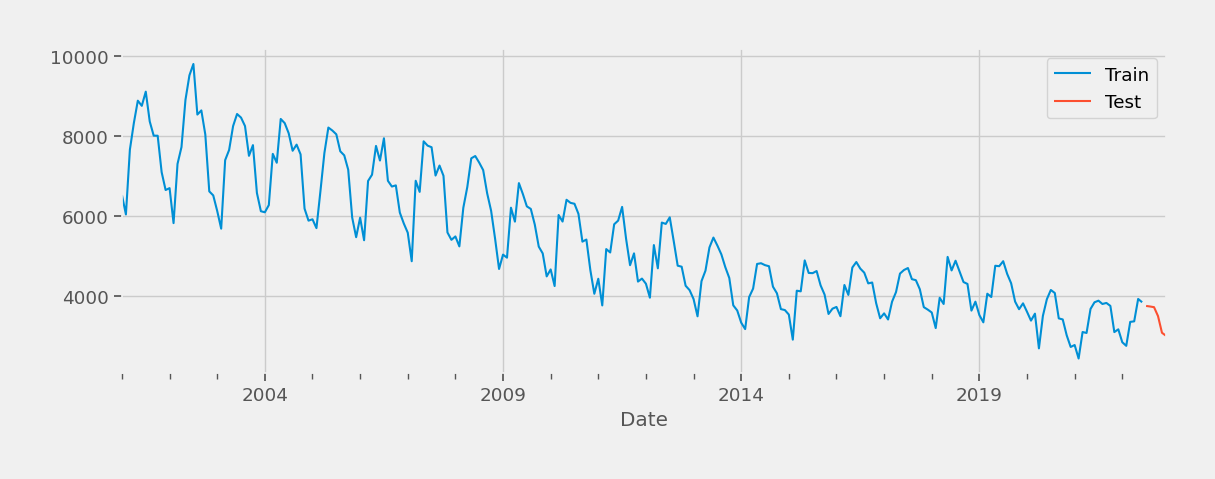

In [ ]:
# tts so test size is 6 lags
train, test = train_test_split(ts_2, test_size= 6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [ ]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1# nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima_model1= tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima_model1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         'BATTERY'   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1860.368
Date:                           Thu, 19 Sep 2024   AIC                           3728.737
Time:                                   09:51:20   BIC                           3742.933
Sample:                               01-01-2001   HQIC                          3734.446
                                    - 06-01-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5296      0.061      8.669      0.000       0.410       0.649
ma.L1         -0.9463      0.022    -42.129      0.000      -0.990      -0.902
ar.S.L12       0.8157      0.028     28.662      0.000       0.760       0.872
sigma2      1.021e+05   9079.720     11.244      0.000    8.43e+04     1.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.43   Prob(JB):                         0.70
Heteroskedasticity (H):               0.40   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

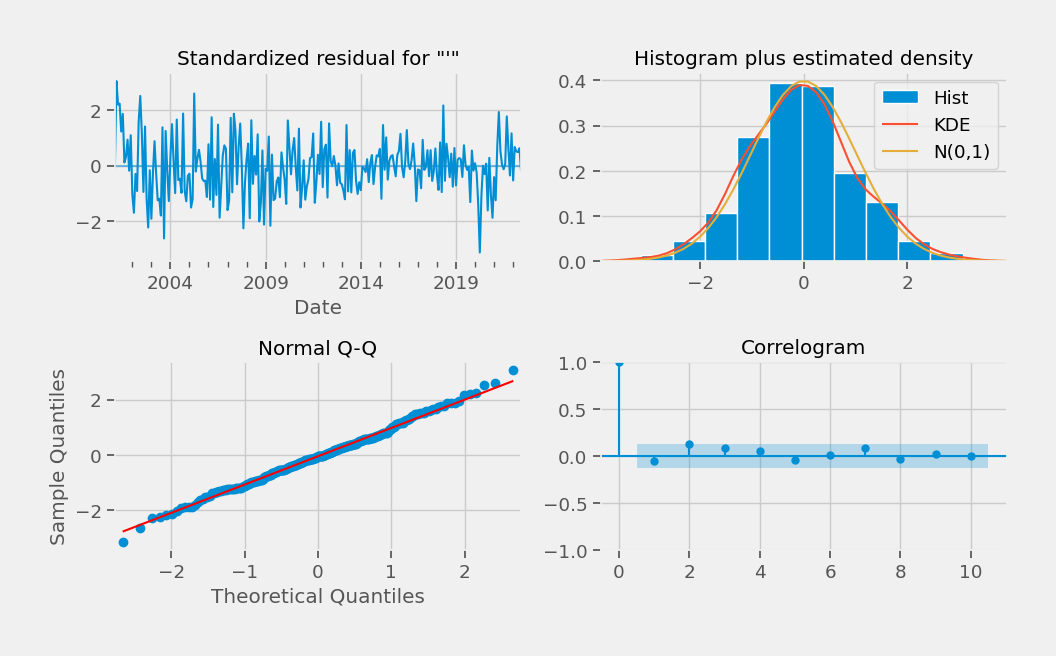

In [ ]:
# Obtain diagnostic plots
fig = sarima_model1.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

-  Normal Q-Q Plot  the points  on the line  the residuals arenormally distributed.
- There is no significant lags in the correlogram of residuals-but may be there is on on lag 2
- Standardized Residuals Over Time is not constant  there is a variance( magnitude of a peak)

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 79.452
- MSE = 10,740.777
- RMSE = 103.638
- R^2 = 0.889
- MAPE = 2.40%


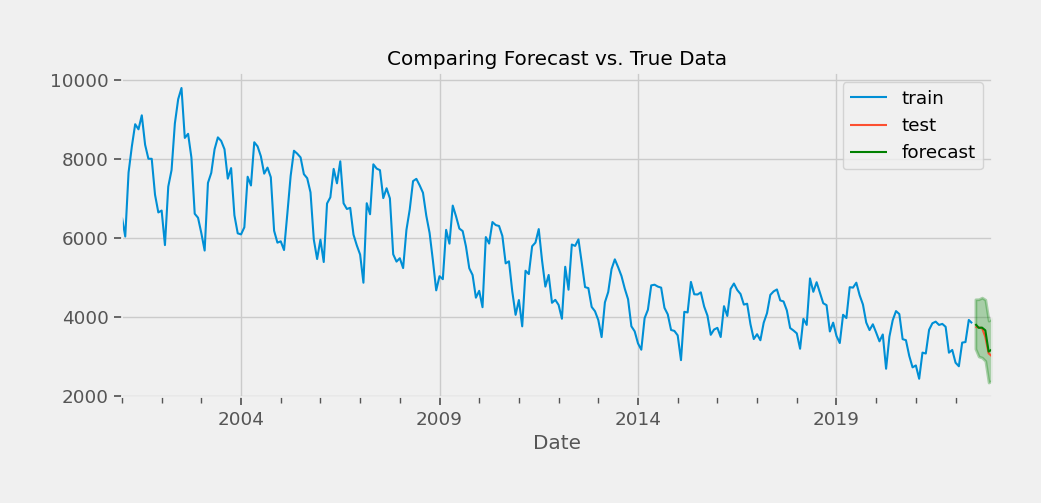

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima_model1.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

# MAPE = 2.3%
- R2 = 0.89
- AIC=	3728.737
-   no negative R-squared suggests that the ARIMA model was capturing the underlying patterns in the time series data effectively. not like the case be for
#Loop through variations looking for better model

In [ ]:
import itertools
# Define the value or range of values for p, d, q
p_values = range(0, 4)
d_values = [1]
q_values = range(0, 4)
P_values = range (0, 4)
D_values = [0]
Q_values = range (0,4)
m = [12]
# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))
# Display first 10 combinations
pdqPDQm_to_try[:10]



[(0, 1, 0, 0, 0, 0, 12),
 (0, 1, 0, 0, 0, 1, 12),
 (0, 1, 0, 0, 0, 2, 12),
 (0, 1, 0, 0, 0, 3, 12),
 (0, 1, 0, 1, 0, 0, 12),
 (0, 1, 0, 1, 0, 1, 12),
 (0, 1, 0, 1, 0, 2, 12),
 (0, 1, 0, 1, 0, 3, 12),
 (0, 1, 0, 2, 0, 0, 12),
 (0, 1, 0, 2, 0, 1, 12)]

In [ ]:
# define starting aic as infinity
best_aic = float("inf")
# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)
# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)

    model = tsa.ARIMA(train, order=order, seasonal_order = seasonal_order)
    try:
        result = model.fit()
        print(pdqPDQm, result.aic)

    except:
        print(f'{pdqPDQm}: caused an error')

    # If lower, replace best AIC with new value
    if result.aic < best_aic:

        best_aic = result.aic
        best_pdqPDQm = pdqPDQm
# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)



(0, 1, 0, 0, 0, 0, 12) 3997.267337599015
(0, 1, 0, 0, 0, 1, 12) 3873.145537339765
(0, 1, 0, 0, 0, 2, 12) 3842.874840711275
(0, 1, 0, 0, 0, 3, 12) 3812.533708185475
(0, 1, 0, 1, 0, 0, 12) 3776.6071306287768
(0, 1, 0, 1, 0, 1, 12) 3703.329972781673
(0, 1, 0, 1, 0, 2, 12) 3705.320765724317
(0, 1, 0, 1, 0, 3, 12) 3697.7137336426476
(0, 1, 0, 2, 0, 0, 12) 3748.6637674250233
(0, 1, 0, 2, 0, 1, 12) 3705.324315583164
(0, 1, 0, 2, 0, 2, 12) 3704.5435417249964


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 0, 2, 0, 3, 12) 3703.731783335691
(0, 1, 0, 3, 0, 0, 12) 3719.260898459769
(0, 1, 0, 3, 0, 1, 12) 3700.478606088989


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 0, 3, 0, 2, 12) 3701.4096454689843
(0, 1, 0, 3, 0, 3, 12) 3706.1543510468805
(0, 1, 1, 0, 0, 0, 12) 3998.9814409998494
(0, 1, 1, 0, 0, 1, 12) 3870.088421540396
(0, 1, 1, 0, 0, 2, 12) 3836.972683331921
(0, 1, 1, 0, 0, 3, 12) 3800.1360387314453
(0, 1, 1, 1, 0, 0, 12) 3743.968970570757
(0, 1, 1, 1, 0, 1, 12) 3671.524184737278
(0, 1, 1, 1, 0, 2, 12) 3673.381370239467
(0, 1, 1, 1, 0, 3, 12) 3663.663505024296
(0, 1, 1, 2, 0, 0, 12) 3709.10051531539
(0, 1, 1, 2, 0, 1, 12) 3705.5191804293154
(0, 1, 1, 2, 0, 2, 12) 3772.6979950364903
(0, 1, 1, 2, 0, 3, 12) 3701.636445571381
(0, 1, 1, 3, 0, 0, 12) 3676.668922816063


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 1, 3, 0, 1, 12) 3700.092544959781
(0, 1, 1, 3, 0, 2, 12) 3736.914706417544


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 1, 3, 0, 3, 12) 3754.407940765019
(0, 1, 2, 0, 0, 0, 12) 3940.589563235152
(0, 1, 2, 0, 0, 1, 12) 3855.155759301957
(0, 1, 2, 0, 0, 2, 12) 3829.5320623400257
(0, 1, 2, 0, 0, 3, 12) 3799.372637162859
(0, 1, 2, 1, 0, 0, 12) 3740.6565169350097
(0, 1, 2, 1, 0, 1, 12) 3667.2810742996207
(0, 1, 2, 1, 0, 2, 12) 3669.0664926796653


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 1, 0, 3, 12) 3658.3861163689157
(0, 1, 2, 2, 0, 0, 12) 3705.34847658894


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 2, 0, 1, 12) 3679.663851349257


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 2, 0, 2, 12) 3719.4269594503903
(0, 1, 2, 2, 0, 3, 12) 3728.7396499332845
(0, 1, 2, 3, 0, 0, 12) 3671.860400499223


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 3, 0, 1, 12) 3696.5711172767133
(0, 1, 2, 3, 0, 2, 12) 3734.1581094992607
(0, 1, 2, 3, 0, 3, 12): caused an error
(0, 1, 3, 0, 0, 0, 12) 3982.8865563269355
(0, 1, 3, 0, 0, 1, 12) 3861.1272715504924
(0, 1, 3, 0, 0, 2, 12) 3826.2789845204125
(0, 1, 3, 0, 0, 3, 12) 3788.9499603869604
(0, 1, 3, 1, 0, 0, 12) 3735.501963321937
(0, 1, 3, 1, 0, 1, 12) 3662.0924358599796
(0, 1, 3, 1, 0, 2, 12) 3663.9190293234924
(0, 1, 3, 1, 0, 3, 12) 3698.186082425778
(0, 1, 3, 2, 0, 0, 12) 3701.974552003374


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 3, 2, 0, 1, 12) 3694.571948051281


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 3, 2, 0, 2, 12) 3743.8679322027137
(0, 1, 3, 2, 0, 3, 12) 3686.349521282095
(0, 1, 3, 3, 0, 0, 12) 3669.43908225468


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 3, 3, 0, 1, 12) 3659.1883263696627
(0, 1, 3, 3, 0, 2, 12): caused an error
(0, 1, 3, 3, 0, 3, 12): caused an error
(1, 1, 0, 0, 0, 0, 12) 3998.7901410437776
(1, 1, 0, 0, 0, 1, 12) 3868.2504508902766
(1, 1, 0, 0, 0, 2, 12) 3834.7267710728015
(1, 1, 0, 0, 0, 3, 12) 3798.396568342106
(1, 1, 0, 1, 0, 0, 12) 3751.4127329763883
(1, 1, 0, 1, 0, 1, 12) 3679.0527875029475
(1, 1, 0, 1, 0, 2, 12) 3680.9859310337697
(1, 1, 0, 1, 0, 3, 12) 3713.0429201632796
(1, 1, 0, 2, 0, 0, 12) 3719.7159150184852
(1, 1, 0, 2, 0, 1, 12) 3708.62245702548
(1, 1, 0, 2, 0, 2, 12): caused an error
(1, 1, 0, 2, 0, 3, 12) 3701.29990752295
(1, 1, 0, 3, 0, 0, 12) 3689.2493442070395
(1, 1, 0, 3, 0, 1, 12) 3705.0432845166133


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0, 3, 0, 2, 12) 3713.4469932172606
(1, 1, 0, 3, 0, 3, 12): caused an error
(1, 1, 1, 0, 0, 0, 12) 3994.198355917335
(1, 1, 1, 0, 0, 1, 12) 3867.0203519348925
(1, 1, 1, 0, 0, 2, 12) 3833.954378646298
(1, 1, 1, 0, 0, 3, 12) 3800.159334404414


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 1, 0, 0, 12) 3728.7368967611683
(1, 1, 1, 1, 0, 1, 12) 3700.4885850355886
(1, 1, 1, 1, 0, 2, 12) 3728.530388603345


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 1, 0, 3, 12) 3700.255082241079
(1, 1, 1, 2, 0, 0, 12): caused an error
(1, 1, 1, 2, 0, 1, 12) 3731.766000057129
(1, 1, 1, 2, 0, 2, 12) 3726.127939532171
(1, 1, 1, 2, 0, 3, 12) 3793.1573159419213


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 3, 0, 0, 12) 3722.0652618010236


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 3, 0, 1, 12) 313.24586420991847
(1, 1, 1, 3, 0, 2, 12) 3736.5556566953915
(1, 1, 1, 3, 0, 3, 12): caused an error
(1, 1, 2, 0, 0, 0, 12) 3941.2268127553016
(1, 1, 2, 0, 0, 1, 12) 3856.8114987172726
(1, 1, 2, 0, 0, 2, 12) 3831.3781640543903
(1, 1, 2, 0, 0, 3, 12) 3801.334399371203
(1, 1, 2, 1, 0, 0, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 1, 0, 1, 12) 3692.7399245182723
(1, 1, 2, 1, 0, 2, 12): caused an error
(1, 1, 2, 1, 0, 3, 12) 3786.740918239766
(1, 1, 2, 2, 0, 0, 12): caused an error
(1, 1, 2, 2, 0, 1, 12) 3726.5472888567538
(1, 1, 2, 2, 0, 2, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 2, 0, 3, 12) 3793.4396809006594
(1, 1, 2, 3, 0, 0, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 3, 0, 1, 12) 3732.065296552675
(1, 1, 2, 3, 0, 2, 12): caused an error
(1, 1, 2, 3, 0, 3, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 3, 0, 0, 0, 12) 3942.1492580065005


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 3, 0, 0, 1, 12) 3857.8586106761186


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 3, 0, 0, 2, 12) 3832.955134066111


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3, 0, 0, 3, 12) 3801.9219168249747


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(1, 1, 3, 1, 0, 0, 12) 3728.038596054933
(1, 1, 3, 1, 0, 1, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 3, 1, 0, 2, 12) 3698.1059091560337


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3, 1, 0, 3, 12) 3675.790494452278


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 3, 2, 0, 0, 12) 3707.7096313805796


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(1, 1, 3, 2, 0, 1, 12) 3702.192352433718


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 3, 2, 0, 2, 12) 3723.7746402012895


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3, 2, 0, 3, 12) 3671.062289166155


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3, 3, 0, 0, 12) 3674.647066610858


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3, 3, 0, 1, 12) 3674.6421100829602


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3, 3, 0, 2, 12) 3699.6567025138256


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3, 3, 0, 3, 12) 3681.9584574740265
(2, 1, 0, 0, 0, 0, 12) 3968.2754846298403
(2, 1, 0, 0, 0, 1, 12) 3862.1425307989534
(2, 1, 0, 0, 0, 2, 12) 3832.253709511334
(2, 1, 0, 0, 0, 3, 12) 3800.0630187900274
(2, 1, 0, 1, 0, 0, 12) 3749.428958086068
(2, 1, 0, 1, 0, 1, 12) 3677.0367878412026
(2, 1, 0, 1, 0, 2, 12) 3678.9699895824483


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 0, 1, 0, 3, 12) 3679.967471810302
(2, 1, 0, 2, 0, 0, 12) 3716.450579086133
(2, 1, 0, 2, 0, 1, 12) 3708.57102148822
(2, 1, 0, 2, 0, 2, 12) 3755.7396793414746
(2, 1, 0, 2, 0, 3, 12) 3719.2663343674653
(2, 1, 0, 3, 0, 0, 12) 3684.446019702784


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 0, 3, 0, 1, 12) 3703.565336037578
(2, 1, 0, 3, 0, 2, 12) 3747.3537336220447
(2, 1, 0, 3, 0, 3, 12) 3758.4796194075734
(2, 1, 1, 0, 0, 0, 12) 3970.234338651672
(2, 1, 1, 0, 0, 1, 12) 3864.0285628886863
(2, 1, 1, 0, 0, 2, 12) 3834.23973814055
(2, 1, 1, 0, 0, 3, 12) 3779.1175189780943
(2, 1, 1, 1, 0, 0, 12) 3740.3166861335853
(2, 1, 1, 1, 0, 1, 12) 12.0
(2, 1, 1, 1, 0, 2, 12) 3686.4412775095375
(2, 1, 1, 1, 0, 3, 12): caused an error
(2, 1, 1, 2, 0, 0, 12) 3723.564540275676
(2, 1, 1, 2, 0, 1, 12): caused an error
(2, 1, 1, 2, 0, 2, 12): caused an error
(2, 1, 1, 2, 0, 3, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 3, 0, 0, 12) 3669.985770761853


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 3, 0, 1, 12) 3728.3473087920365
(2, 1, 1, 3, 0, 2, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 3, 0, 3, 12) 3709.253209510466
(2, 1, 2, 0, 0, 0, 12) 3941.4986056703656
(2, 1, 2, 0, 0, 1, 12) 3849.4488202045204


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 2, 12) 3814.505839795413


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 3, 12) 3795.5349776981643
(2, 1, 2, 1, 0, 0, 12) 3770.729562950227
(2, 1, 2, 1, 0, 1, 12) 3736.0279268210293
(2, 1, 2, 1, 0, 2, 12) 3714.9514407967304


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 1, 0, 3, 12) 3753.4282839270045
(2, 1, 2, 2, 0, 0, 12) 3748.2753543393196
(2, 1, 2, 2, 0, 1, 12): caused an error
(2, 1, 2, 2, 0, 2, 12) 3770.65903490572
(2, 1, 2, 2, 0, 3, 12) 3780.4924897998253
(2, 1, 2, 3, 0, 0, 12): caused an error
(2, 1, 2, 3, 0, 1, 12) 3731.0090005465468
(2, 1, 2, 3, 0, 2, 12): caused an error
(2, 1, 2, 3, 0, 3, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 0, 0, 0, 12) 3931.1113235587354


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 0, 0, 1, 12) 3847.2981303295574


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 0, 0, 2, 12) 3821.3180647547597


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 0, 0, 3, 12) 3809.981854422645


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 1, 0, 0, 12): caused an error
(2, 1, 3, 1, 0, 1, 12) 3744.3064556318304


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 1, 0, 2, 12) 3748.4868171725548


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 1, 0, 3, 12) 3744.4156165641057


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 2, 0, 0, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 2, 0, 1, 12) 3745.9689188866796


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 2, 0, 2, 12) 3744.764277177269


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 2, 0, 3, 12): caused an error
(2, 1, 3, 3, 0, 0, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 3, 0, 1, 12) 3730.7595676086366


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 3, 3, 0, 2, 12) 3747.749583084444


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 3, 0, 3, 12) 3746.211237994735
(3, 1, 0, 0, 0, 0, 12) 3970.022557164564
(3, 1, 0, 0, 0, 1, 12) 3863.7410150724445
(3, 1, 0, 0, 0, 2, 12) 3834.2106166914896
(3, 1, 0, 0, 0, 3, 12) 3801.814077185168
(3, 1, 0, 1, 0, 0, 12) 3750.024927151301


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 0, 1, 0, 1, 12) 3677.3218640353643
(3, 1, 0, 1, 0, 2, 12) 3679.218856684862


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 0, 1, 0, 3, 12) 3669.156544335793
(3, 1, 0, 2, 0, 0, 12) 3716.330232615008
(3, 1, 0, 2, 0, 1, 12) 3709.9409561574494
(3, 1, 0, 2, 0, 2, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 0, 2, 0, 3, 12) 3712.9575198165476
(3, 1, 0, 3, 0, 0, 12) 3684.616012499152


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 0, 3, 0, 1, 12) 3704.6966203990205
(3, 1, 0, 3, 0, 2, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 0, 3, 0, 3, 12) 3711.7559529263985
(3, 1, 1, 0, 0, 0, 12) 3899.210001259312


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 0, 0, 1, 12) 3861.1612750463864
(3, 1, 1, 0, 0, 2, 12) 3836.2811054838735
(3, 1, 1, 0, 0, 3, 12) 3804.0732660174617


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 1, 0, 0, 12) 3740.57369612971


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 1, 0, 1, 12) 3748.649928086687


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 1, 0, 2, 12) 3715.8889135503614


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 1, 0, 3, 12) 3674.7019359224214
(3, 1, 1, 2, 0, 0, 12) 3722.999584834263
(3, 1, 1, 2, 0, 1, 12) 3784.934488893732


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 2, 0, 2, 12) 3799.861247010547


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 2, 0, 3, 12) 3773.566476638536
(3, 1, 1, 3, 0, 0, 12) 3688.168458485451


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 3, 0, 1, 12) 3719.329365299366
(3, 1, 1, 3, 0, 2, 12) 3768.4611011077786


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 1, 3, 0, 3, 12) 3801.8156471310863


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 0, 0, 0, 12) 3786.71208477003


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 0, 0, 1, 12) 3761.7600989012026


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 0, 0, 2, 12) 3798.612285804625


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 0, 0, 3, 12) 3748.725809453149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 1, 0, 0, 12) 3743.7444071408304
(3, 1, 2, 1, 0, 1, 12) 3744.2118134381712


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 1, 0, 2, 12) 3683.9275707057027


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 1, 0, 3, 12) 3673.009926985082


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 2, 0, 0, 12) 3782.9475124183828


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 2, 0, 1, 12) 3673.7947718284768


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 2, 0, 2, 12) 3776.5037342935093


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 2, 0, 3, 12) 3685.855792718251


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 3, 0, 0, 12) 3690.342415563635


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 3, 0, 1, 12) 3666.5346284872358


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2, 3, 0, 2, 12) 3747.0222101152203
(3, 1, 2, 3, 0, 3, 12) 3766.075781279905


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(3, 1, 3, 0, 0, 0, 12) 3788.008475579759
(3, 1, 3, 0, 0, 1, 12) 3852.629813889597


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(3, 1, 3, 0, 0, 2, 12) 3805.6438570113287


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 0, 0, 3, 12) 3779.09947355829


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3, 1, 0, 0, 12) 3736.7452661080592


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(3, 1, 3, 1, 0, 1, 12) 3666.046587658447


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 1, 0, 2, 12) 3732.347145801843


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 1, 0, 3, 12) 3695.5102563068713


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

(3, 1, 3, 2, 0, 0, 12) 3714.161944840167
(3, 1, 3, 2, 0, 1, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 2, 0, 2, 12) 3718.45229886338


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3, 2, 0, 3, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 3, 0, 0, 12) 3728.9205142711153


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3, 3, 0, 1, 12): caused an error


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 3, 0, 2, 12) 3698.958848684213


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3, 3, 0, 3, 12): caused an error
Best AIC: 12.0
Best pdqPDQm: (2, 1, 1, 1, 0, 1, 12)


# the best pdqPDQm from Loop through variations
- pdqPDQm =(2,1,1,1,0,1,12)

In [ ]:
# Orders for non seasonal components
p = 2# nonseasonal AR
d = 1# nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima_model2= tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima_model2.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        'BATTERY'   No. Observations:                  258
Model:             ARIMA(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                   0.000
Date:                          Thu, 19 Sep 2024   AIC                             12.000
Time:                                  11:08:37   BIC                             33.294
Sample:                              01-01-2001   HQIC                            20.564
                                   - 06-01-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0356   6.68e-09   5.33e+06      0.000       0.036       0.036
ar.L2          0.9644   7.38e-08   1.31e+07      0.000       0.964       0.964
ma.L1         -0.9990   1.27e-23  -7.88e+22      0.000      -0.999      -0.999
ar.S.L12       1.0000    6.7e-08   1.49e+07      0.000       1.000       1.000
ma.S.L12      -0.9968   4.53e-08   -2.2e+07      0.000      -0.997      -0.997
sigma2      9640.1818         -0       -inf      0.000    9640.182    9640.182
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

almost the same
-  Normal Q-Q Plot  the points  strlitly sround the line  the residuals are not normally distributed, which can affect the validity of the model's predictions.
- There are significant lags in the correlogram of residuals-it indicates our model has missed something.
- Standardized Residuals Over Time is not constant  there is a variance( magnitude of a peak befor 2004)

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df1 = sarima_model2.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df1);
# Obtain metrics
regression_metrics_ts(test, forecast_df1['mean'])

#This model is worst than the first model
- R2 is negtive
- MAPE is larger = 6.9% and is was 5.3%
- slightly improvment in AIC = 4513.55


#**Auto_Arima**

In [ ]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True
)



Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,2)(1,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 705, in fit
    mlefit = super().fit(start_params, method=method,
  File "/usr/local/lib/python3.10/dist-packa

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3999.181, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3753.329, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3872.017, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3997.267, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4000.706, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=4.27 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3680.746, Time=2.62 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3870.170, Time=0.39 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3687.290, Time=3.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3682.671, Time=2.49 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3836.662, Time=1.12 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=7.96 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3704.855, Time=1.07 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3678.763, Time=1.39 sec
 ARIMA(2,1,

# the best( pdqPDQm )from Auto_Arima
pdqPDQm = (1,1,0,1,0,1,12)

In [ ]:
# Orders for non seasonal components
p = 2 # nonseasonal AR
d = 1# nonseasonal differencing
q = 0 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima_model3= tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          'BATTERY'   No. Observations:                  258
Model:             ARIMA(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1833.518
Date:                            Thu, 19 Sep 2024   AIC                           3677.037
Time:                                    11:12:07   BIC                           3694.782
Sample:                                01-01-2001   HQIC                          3684.173
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3591      0.056     -6.389      0.000      -0.469      -0.249
ar.L2         -0.1261      0.055     -2.290      0.022      -0.234      -0.018
ar.S.L12       0.9840      0.006    169.149      0.000       0.973       0.995
ma.S.L12      -0.6853      0.057    -12.115      0.000      -0.796      -0.574
sigma2      8.026e+04   6989.420     11.484      0.000    6.66e+04     9.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.94   Prob(JB):                         0.40
Heteroskedasticity (H):               0.42   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

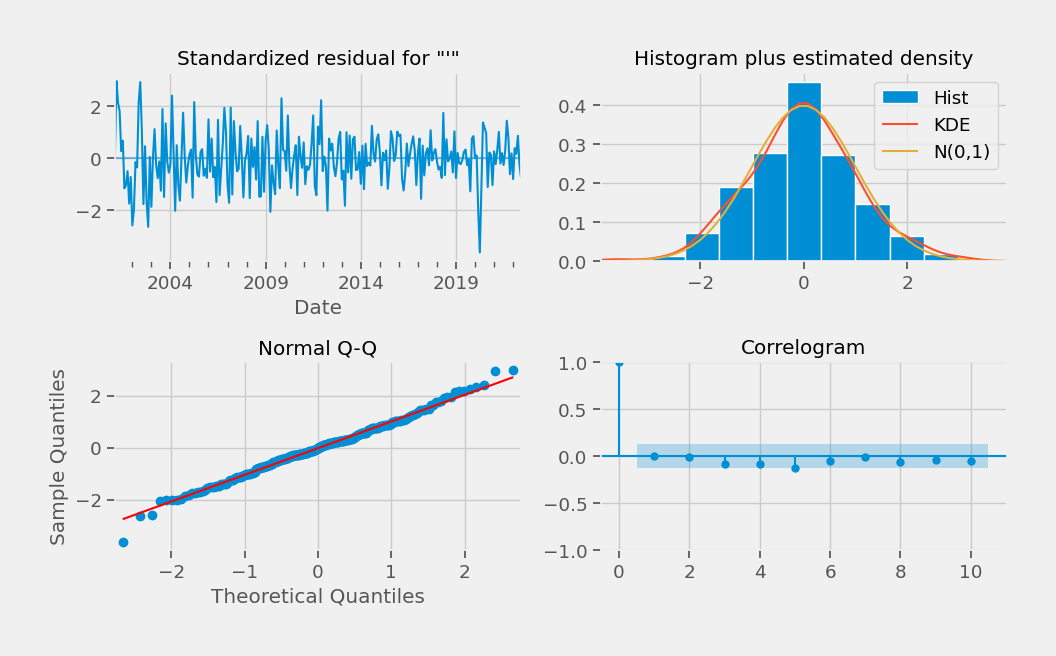

In [ ]:
# Obtain diagnostic plots
fig = sarima_model3.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

-  Normal Q-Q Plot  the points  on the line  the residuals arenormally distributed.
- There is one significant at lag(5)in the correlogram of residuals-
- Standardized Residuals Over Time is not constant  there is a variance( magnitude of a peak)

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 95.190
- MSE = 17,440.843
- RMSE = 132.064
- R^2 = 0.820
- MAPE = 2.61%


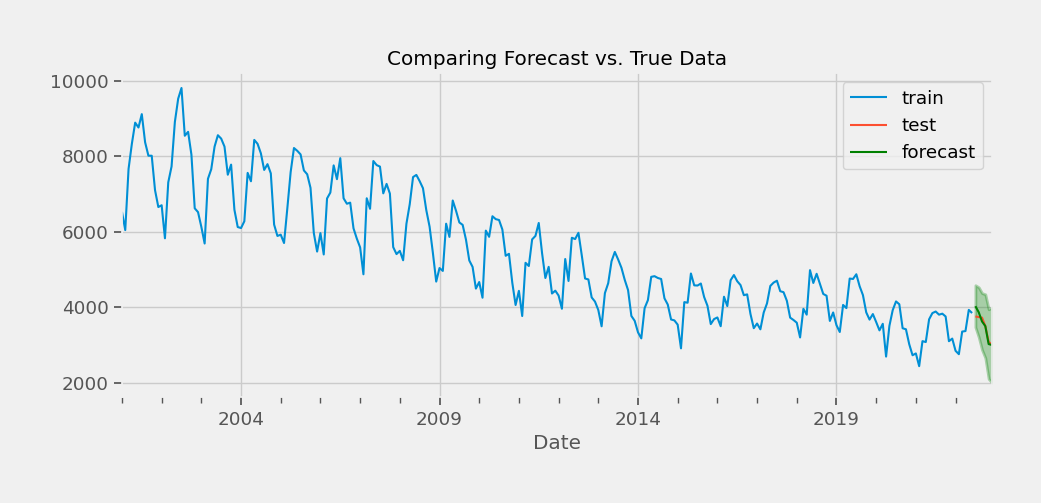

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df2 = sarima_model3.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df2);
# Obtain metrics
regression_metrics_ts(test, forecast_df2['mean'])

#This model is getting  slightly worst than the first model
- R2 =0.82
- MAPE is larger = 2.6%
- slightly improvment in AIC = 3677.037 and was at the first mmodel AIC = 	3728.737


In [ ]:
print("\n","\033[1mComparing models with the same d value\033[0m")
print(f"sarima_model order {(sarima_model1.model.order,sarima_model1.model.seasonal_order)} {regression_metrics_ts(test, forecast_df['mean'])}")
print(f"sarima_model AIC = {sarima_model1.aic.round(2)},\n ")

print(f"sarima_model1 order {(sarima_model2.model.order,sarima_model2.model.seasonal_order)} {regression_metrics_ts(test, forecast_df1['mean'])}")
print(f"sarima_model1 AIC = {sarima_model2.aic.round(2)},\n ")

print(f"sarima_model2 order {(sarima_model3.model.order,sarima_model3.model.seasonal_order)} {regression_metrics_ts(test, forecast_df2['mean'])}")
print(f"sarima_model2 AIC = {sarima_model3.aic.round(2)},\n ")


 Comparing models with the same d value
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 79.452
- MSE = 10,740.777
- RMSE = 103.638
- R^2 = 0.889
- MAPE = 2.40%
sarima_model order ((1, 1, 1), (1, 0, 0, 12)) None
sarima_model AIC = 3728.74,
 
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3,468.333
- MSE = 12,126,136.000
- RMSE = 3,482.260
- R^2 = -124.270
- MAPE = 100.00%
sarima_model1 order ((2, 1, 1), (1, 0, 1, 12)) None
sarima_model1 AIC = 12.0,
 
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 95.190
- MSE = 17,440.843
- RMSE = 132.064
- R^2 = 0.820
- MAPE = 2.61%
sarima_model2 order ((2, 1, 0), (1, 0, 1, 12)) None
sarima_model2 AIC = 3677.04,
 


# The first model is the best of   MAPE= 2.4%  but the AIC is greater and all othe r is better even with less nlag needed for froecasting

#Make true future forecasts using the entire dataset (for dates beyond the entire ts).

In [ ]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1# nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 0 # Seasonal MA
m = 12 # Seasonal period

final_model= tsa.ARIMA(ts_2, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()



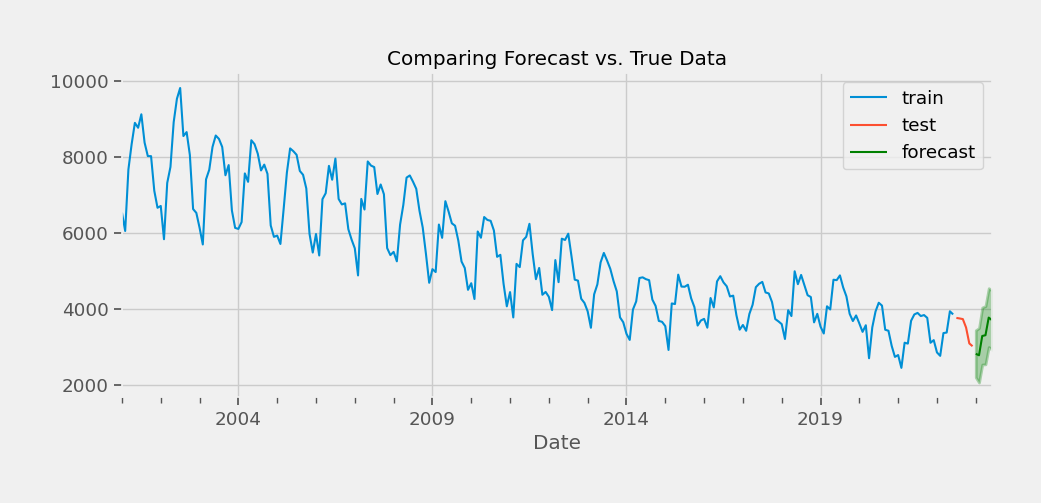

In [ ]:
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [ ]:
starting_value = forecast_df['mean'].iloc[0]
starting_value

2810.013237675124

In [ ]:
# the predicted for 6 months into the future
final_value = forecast_df['mean'].iloc[-1]
final_value


3696.6446107157985

In [ ]:
change = final_value - starting_value
change

886.6313730406746

In [ ]:
#calculate this as a percentage by dividing the delta by the starting value.
perc_change = (change / starting_value) * 100
perc_change



31.552569260286926

In [ ]:
print(f'The allocated period is from {forecast_df.index[0].strftime("%Y-%m-%d")} to {forecast_df.index[-1].strftime("%Y-%m-%d")}.\n')
print(f"The total crime count over the 6 months is {forecast_df['mean'].sum().round(2)} crimes.\n")
print(f"The percent change in crime count at the end of the 6 months is an increase of {perc_change.round(2)}%")

The allocated period is from 2023-01-01 to 2023-06-01.

The total crime count over the 6 months is 19616.68 crimes.

The percent change in crime count at the end of the 6 months is an increase of 31.55%


<ipython-input-290-99104e8dc6ed>:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


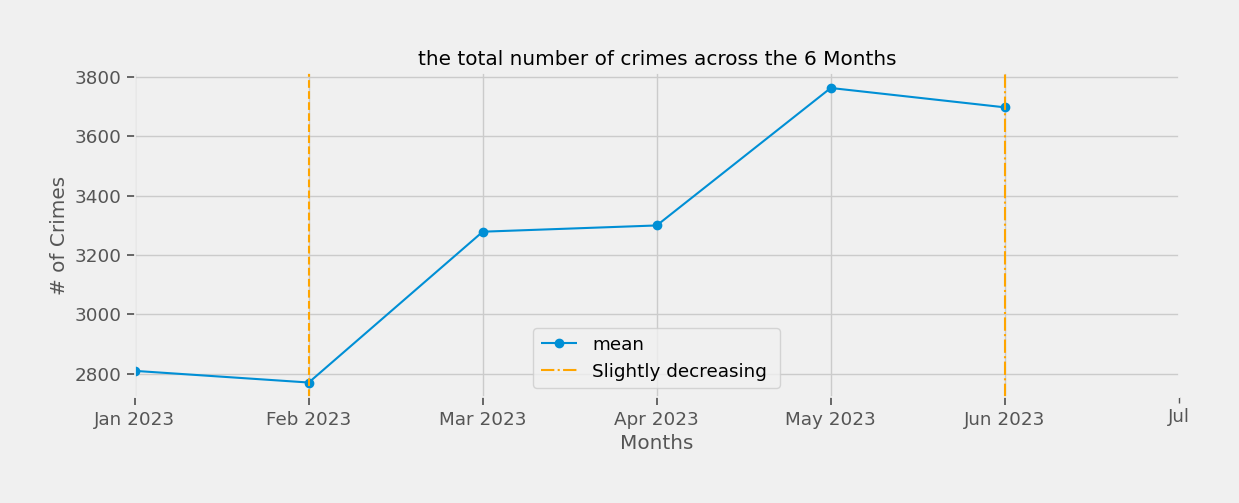

In [ ]:
ax=forecast_df['mean'].plot(style='o-',grid=True,ylabel='# of Crimes', xlabel='Months',title="the total number of crimes across the 6 Months",
                    figsize=(12,4),xticks=forecast_df['mean'].index);
ax.set_xticklabels( [x.strftime('%b %Y') for x in forecast_df['mean'].index], rotation=0)
ax.axvline('2023-02-01', color='orange',ls='--')
ax.axvline('2023-06', color='orange',ls='-.',label='Slightly decreasing ')
ax.legend()
fig.tight_layout()
ax.set_xlim(['2023-01','2023-07'])
fig.savefig('SavedPlot.png', dpi = 300)


In [ ]:
forecast_dfts2=forecast_df

#Summarizing the Forecast
- The allocated period is from 2023-01-01 to 2023-06-01.

- The total crime count over the 6 months is 19616.68 crimes.

- The percent change in crime count at the end of the 6 months is an increase of 31.55%


 <a name='new5'></a>
# ⭐️**comparing between crime count forecas THEFT V BATTERY**
>[Click here](#new0) to jump to up

Text(0.5, 1.0, 'BATTERY')

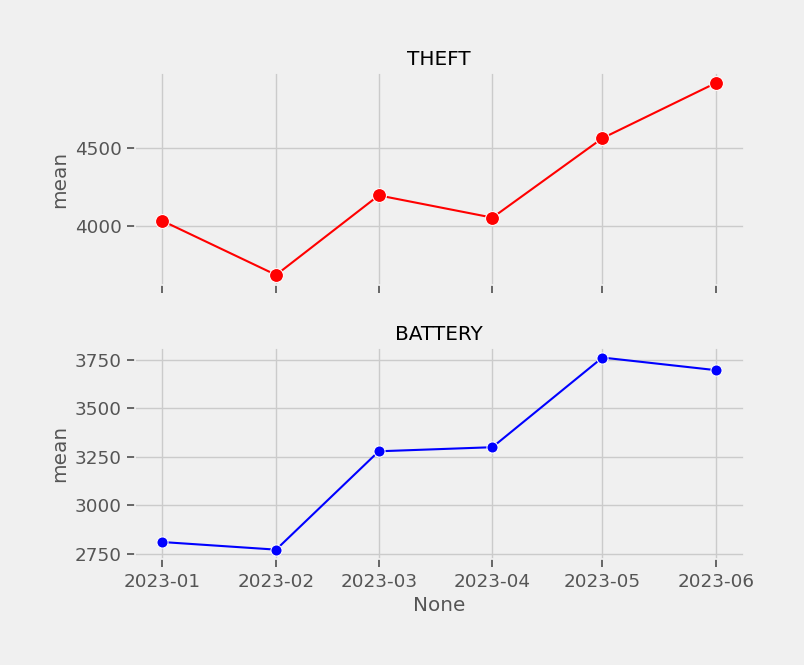

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Import the gridspec module from matplotlib
from matplotlib import gridspec

fig, axes = plt.subplots(nrows=2, figsize=(7,6),
                           sharex=True, gridspec_kw={'hspace': 0.3}) # Use a dictionary to specify gridspec keyword arguments
sns.lineplot(forecast_dfts1,x=forecast_dfts1['mean'].index,y=forecast_dfts1['mean'],errorbar=None,c ='r', marker = 'o', markersize = 10,ax=axes[0]);
axes[0].set_title("THEFT")
sns.lineplot(forecast_dfts2,x=forecast_dfts2['mean'].index,y=forecast_dfts2['mean'],errorbar=None,c ='b', marker = 'o', markersize = 8,ax=axes[1]);
axes[1].set_title("BATTERY")

 <a name='new6'></a>
# ⭐️**Topic 3) Total Crime  count forecast :**
>[Click here](#new0) to jump to up

In [ ]:
# Select all crimes and then resample
ts=df["Crime Type"].resample('MS').size()
ts.name = "All Crimes"
print(f"NUN Value = {ts.isna().sum()}")
print(ts.index)
ts.head(2)

NUN Value = 0
DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='Date', length=264, freq='MS')


,All Crimes
Date,
2001-01-01,38119
2001-02-01,33787


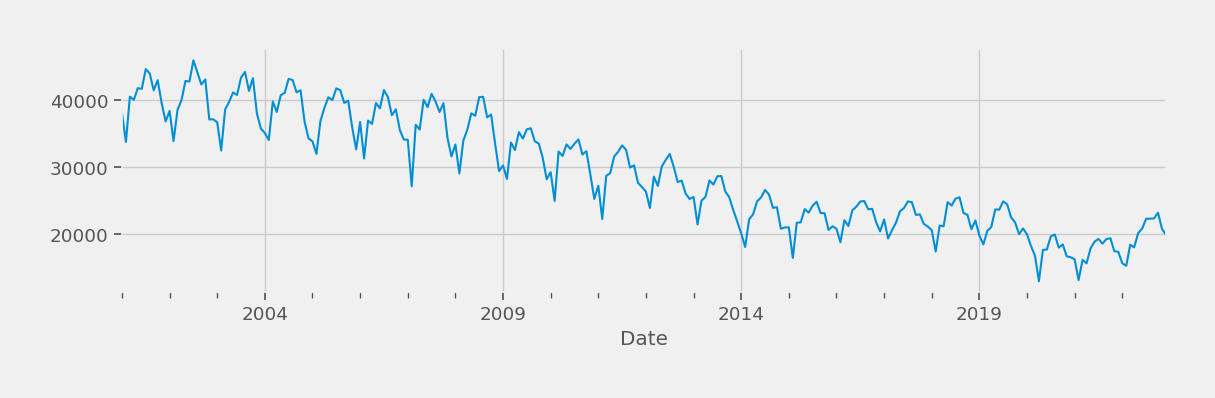

In [ ]:
# Visualize selected time series
ax = ts.plot()

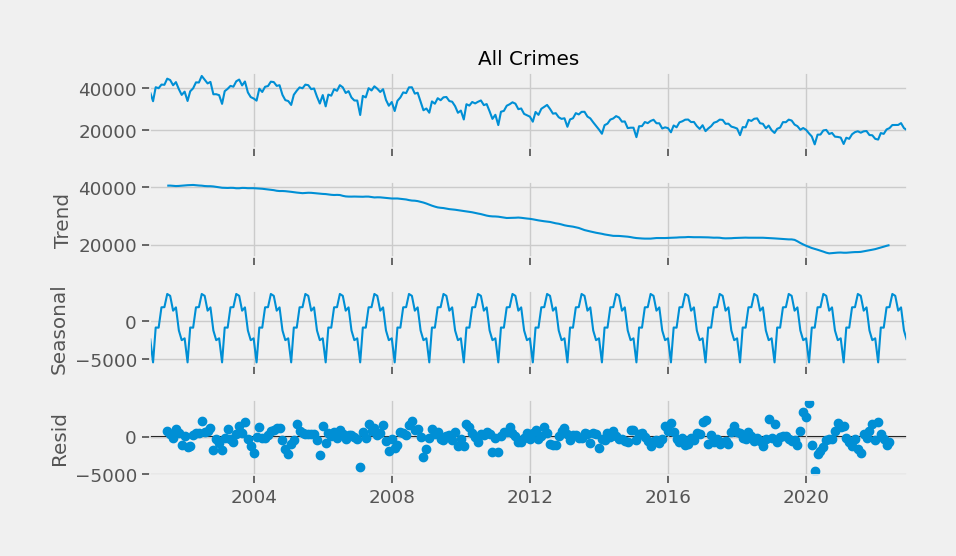

In [ ]:
## Use Seasonal Decompose to check for seasonality
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(9, 5)
fig.tight_layout()

In [ ]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")


The seasonal component is 8897.74404761905 which is ~26.89% of the variation in time series.


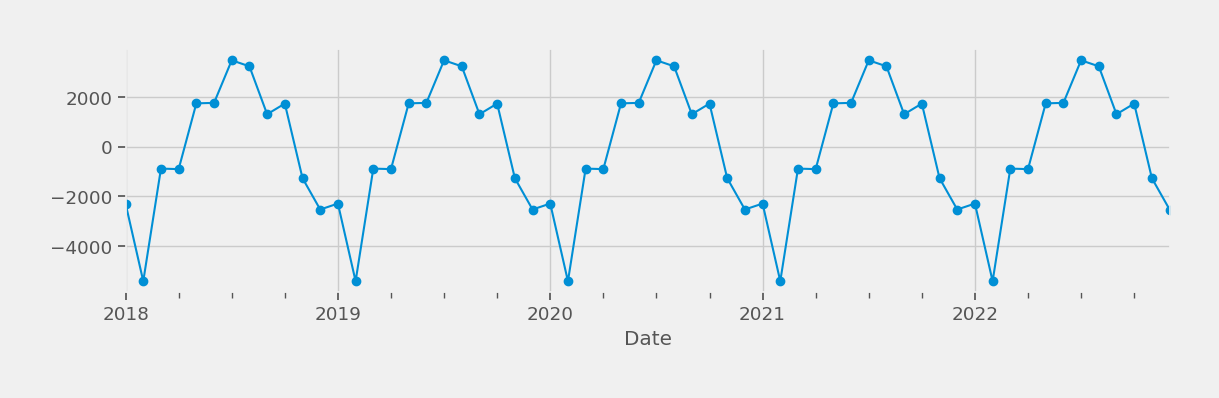

In [ ]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2018': '2022'].plot(marker = 'o')

In [ ]:
# Check for stationarity
get_adfuller_results(ts)


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.325784,15,248,0.617295,0.05,False


In [ ]:
ts_diff = ts.diff().dropna()
get_adfuller_results(ts_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.04041,14,248,0.031289,0.05,True


In [ ]:
# Determine differencing
d = ndiffs(ts)
print(f'd is {d}')
D = nsdiffs(ts, m =12)
print(f'D is {D}')



d is 1
D is 0


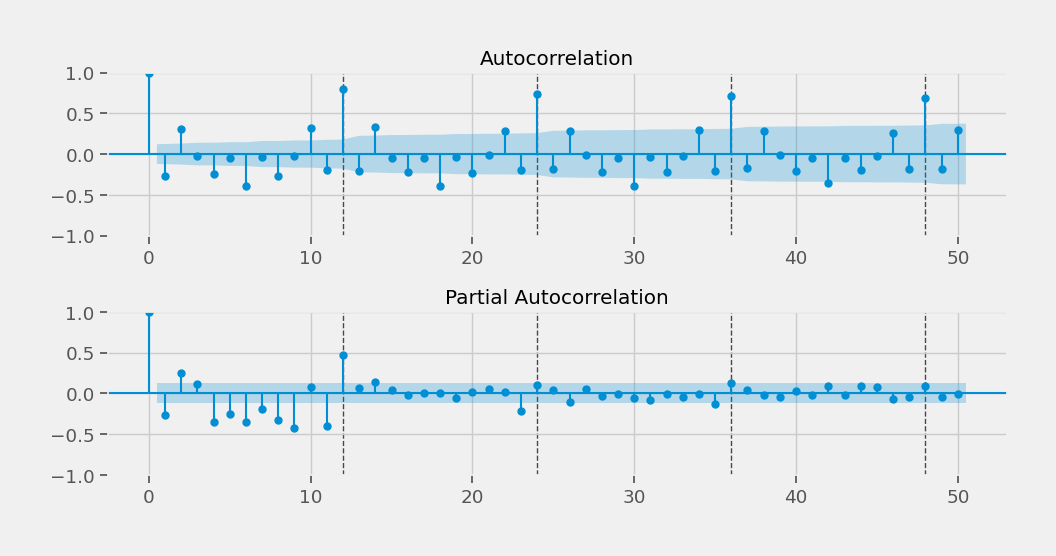

In [ ]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts_diff, annotate_seas = True, m = 12, nlags = 50);

# p and q
- It appears that both the ACF and PACF gradually decrease in magnitude.
- starting with AR(1) and MA(1).
#P and Q
-The seasonal lags in the PACF show a drop off  after snlag 1, and the seasonal lags in the ACF stay consistently high.
- The SPACF plot above shows a very abrupt drop after lag 1. This indicates that we only need one coefficient in our SAR model, known as a seasonal-AR(1) model  , and a seasonal-MA, SMA(0).
# The pbqPBQ=
(1,1,1,1,0,0)

#**Train Test Split**

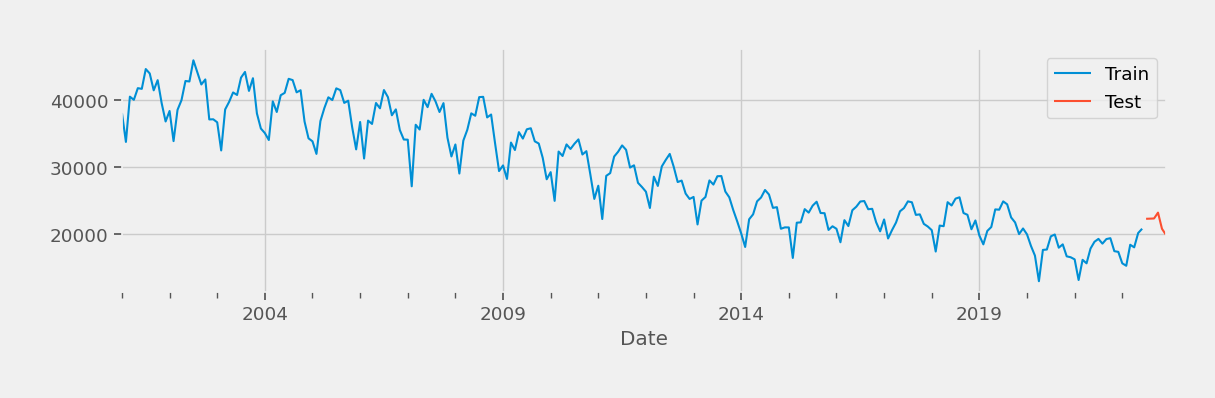

In [ ]:
# tts so test size is 6 lags
test_lags = 6
train, test = train_test_split(ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [ ]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1# nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima_model= tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        All Crimes   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -2289.624
Date:                           Wed, 18 Sep 2024   AIC                           4587.248
Time:                                   21:04:54   BIC                           4601.445
Sample:                               01-01-2001   HQIC                          4592.958
                                    - 06-01-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4897      0.121     -4.046      0.000      -0.727      -0.253
ma.L1          0.3161      0.139      2.277      0.023       0.044       0.588
ar.S.L12       0.5182      0.010     50.381      0.000       0.498       0.538
sigma2      2.756e+06   2.07e+05     13.311      0.000    2.35e+06    3.16e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1582.24
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -1.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

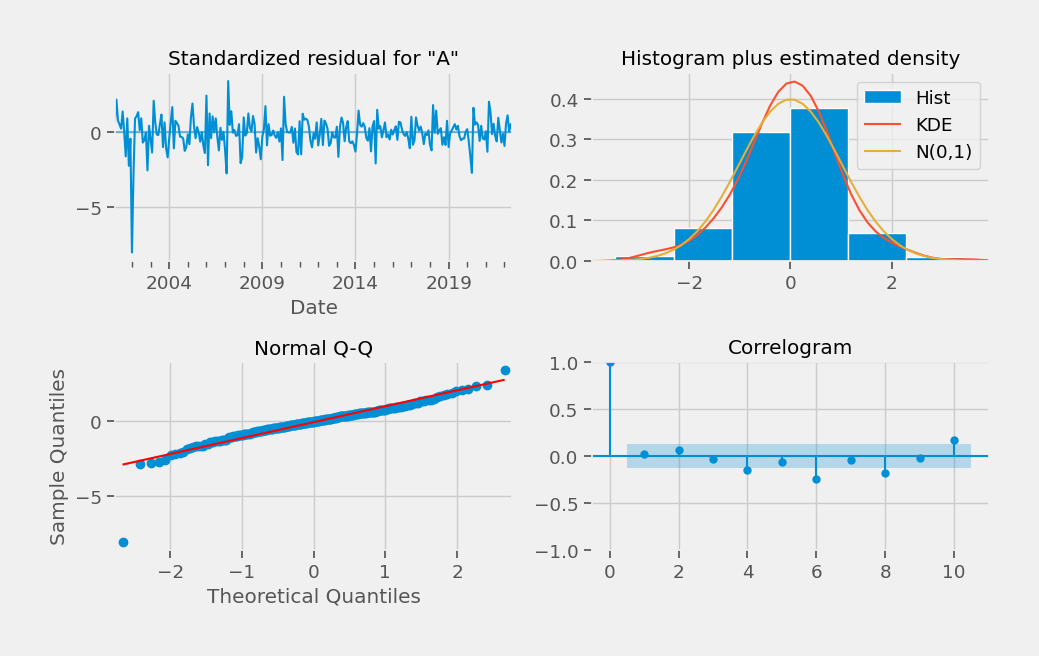

In [ ]:
# Obtain diagnostic plots
fig = sarima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

-  Normal Q-Q Plot  the points  strlitly sround the line  the residuals are not normally distributed, which can affect the validity of the model's predictions.
- There are significant lags in the correlogram of residuals-it indicates our model has missed something.
- Standardized Residuals Over Time is not constant  there is a variance( magnitude of a peak befor 2004)

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,184.870
- MSE = 1,801,172.036
- RMSE = 1,342.078
- R^2 = -0.454
- MAPE = 5.31%


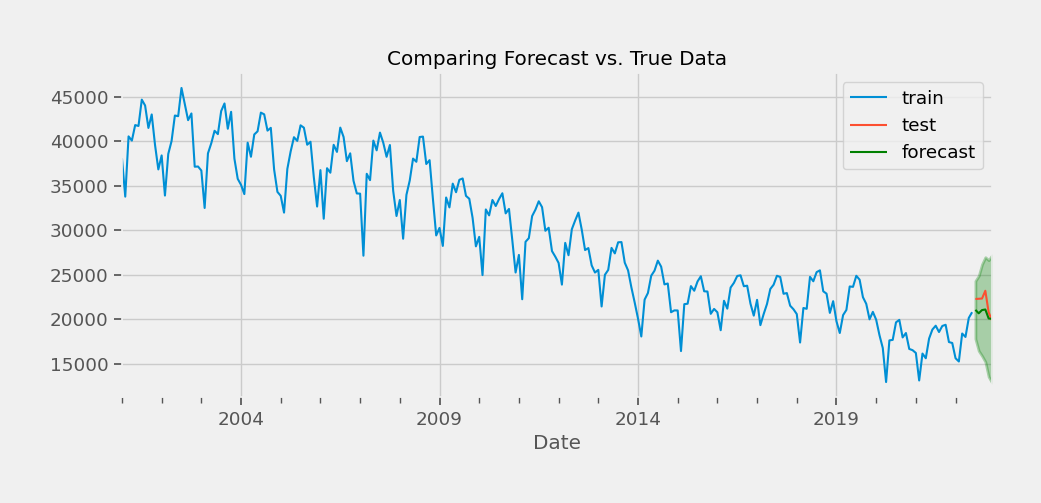

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

# MAPE = 5.3% is larger than 1%
-   A negative R-squared suggests that the ARIMA model may not be capturing the underlying patterns in your time series data effectively. It could be that the chosen model order (pdqPDQm) is inappropriate for your data
#Loop through variations looking for better model

In [ ]:
import itertools
# Define the value or range of values for p, d, q
p_values = range(0, 4)
d_values = [1]
q_values = range(0, 4)
P_values = range (0, 4)
D_values = [0]
Q_values = range (0,4)
m = [12]
# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))
# Display first 10 combinations
pdqPDQm_to_try[:10]



[(0, 1, 0, 0, 0, 0, 12),
 (0, 1, 0, 0, 0, 1, 12),
 (0, 1, 0, 0, 0, 2, 12),
 (0, 1, 0, 0, 0, 3, 12),
 (0, 1, 0, 1, 0, 0, 12),
 (0, 1, 0, 1, 0, 1, 12),
 (0, 1, 0, 1, 0, 2, 12),
 (0, 1, 0, 1, 0, 3, 12),
 (0, 1, 0, 2, 0, 0, 12),
 (0, 1, 0, 2, 0, 1, 12)]

In [ ]:
# define starting aic as infinity
best_aic = float("inf")
# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)
# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)

    model = tsa.ARIMA(train, order=order, seasonal_order = seasonal_order)
    try:
        result = model.fit()
        print(pdqPDQm, result.aic)

    except:
        print(f'{pdqPDQm}: caused an error')

    # If lower, replace best AIC with new value
    if result.aic < best_aic:

        best_aic = result.aic
        best_pdqPDQm = pdqPDQm
# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)



(0, 1, 0, 0, 0, 0, 12) 4754.724919530063
(0, 1, 0, 0, 0, 1, 12) 4657.381146415711
(0, 1, 0, 0, 0, 2, 12) 4638.167901223373
(0, 1, 0, 1, 0, 0, 12) 4602.654488859721
(0, 1, 0, 1, 0, 1, 12) 4527.604418077872
(0, 1, 0, 1, 0, 2, 12) 4529.328331343624
(0, 1, 0, 2, 0, 0, 12) 4579.819532680075
(0, 1, 0, 2, 0, 1, 12) 4529.387077365305


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 0, 2, 0, 2, 12) 4531.562590778487
(0, 1, 1, 0, 0, 0, 12) 4743.3605793511815
(0, 1, 1, 0, 0, 1, 12) 4645.414500415405
(0, 1, 1, 0, 0, 2, 12) 4617.381367890605
(0, 1, 1, 1, 0, 0, 12) 4592.00129048023
(0, 1, 1, 1, 0, 1, 12) 4516.6344464622625
(0, 1, 1, 1, 0, 2, 12) 4518.430511522012
(0, 1, 1, 2, 0, 0, 12) 4569.617840941844
(0, 1, 1, 2, 0, 1, 12) 4518.479132802615
(0, 1, 1, 2, 0, 2, 12) 4520.607043733876
(0, 1, 2, 0, 0, 0, 12) 4697.590424152988
(0, 1, 2, 0, 0, 1, 12) 4623.264993576997
(0, 1, 2, 0, 0, 2, 12) 4600.461908533494
(0, 1, 2, 1, 0, 0, 12) 4582.859092893544
(0, 1, 2, 1, 0, 1, 12) 4513.098265626204


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 1, 0, 2, 12) 4514.930182633188
(0, 1, 2, 2, 0, 0, 12) 4562.422566533556


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 2, 0, 1, 12) 4514.969364351991


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 2, 0, 2, 12) 4514.604331577591
(1, 1, 0, 0, 0, 0, 12) 4736.577736384397
(1, 1, 0, 0, 0, 1, 12) 4640.424140810615
(1, 1, 0, 0, 0, 2, 12) 4613.3847961448355
(1, 1, 0, 1, 0, 0, 12) 4588.811161489939
(1, 1, 0, 1, 0, 1, 12) 4514.396698142762
(1, 1, 0, 1, 0, 2, 12) 4516.215094318895
(1, 1, 0, 2, 0, 0, 12) 4566.760226378645
(1, 1, 0, 2, 0, 1, 12) 4516.258854157872


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0, 2, 0, 2, 12) 4518.39644907116
(1, 1, 1, 0, 0, 0, 12) 4729.252390568193
(1, 1, 1, 0, 0, 1, 12) 4636.944683167456
(1, 1, 1, 0, 0, 2, 12) 4609.591417451951
(1, 1, 1, 1, 0, 0, 12) 4587.248449402903


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 1, 0, 1, 12) 4530.526414890824
(1, 1, 1, 1, 0, 2, 12) 4532.246365255074


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 2, 0, 0, 12) 4574.567435919754


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 2, 0, 1, 12) 4534.73225147583


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 2, 0, 2, 12) 4519.330648816057
(1, 1, 2, 0, 0, 0, 12) 4699.487252757943
(1, 1, 2, 0, 0, 1, 12) 4625.241413073656
(1, 1, 2, 0, 0, 2, 12) 4602.101520129911
(1, 1, 2, 1, 0, 0, 12) 4584.618051682107
(1, 1, 2, 1, 0, 1, 12) 4520.571186184128


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 1, 0, 2, 12) 4521.546357655104
(1, 1, 2, 2, 0, 0, 12) 4563.810321652456


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 2, 0, 1, 12) 4518.929730695725


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 2, 0, 2, 12) 4529.419465378436
(2, 1, 0, 0, 0, 0, 12) 4714.728771635227
(2, 1, 0, 0, 0, 1, 12) 4630.411343651102
(2, 1, 0, 0, 0, 2, 12) 4604.094914367783
(2, 1, 0, 1, 0, 0, 12) 4584.653367430096
(2, 1, 0, 1, 0, 1, 12) 4513.232340007944
(2, 1, 0, 1, 0, 2, 12) 4515.083047308166
(2, 1, 0, 2, 0, 0, 12) 4563.08993660809
(2, 1, 0, 2, 0, 1, 12) 4515.117605455946


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 0, 2, 0, 2, 12) 4547.612639858022
(2, 1, 1, 0, 0, 0, 12) 4715.658920448606
(2, 1, 1, 0, 0, 1, 12) 4631.756265266215


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 0, 0, 2, 12) 4605.954193314512


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 1, 0, 0, 12) 4588.2777346598705
(2, 1, 1, 1, 0, 1, 12) 4515.2321251142375


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 1, 0, 2, 12) 4540.625072922436


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 2, 0, 0, 12) 4565.396995577174


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 2, 0, 1, 12) 4519.662634341202


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 2, 0, 2, 12) 4592.543599890443
(2, 1, 2, 0, 0, 0, 12) 4699.311394565244
(2, 1, 2, 0, 0, 1, 12) 4623.9654340830875


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 2, 12) 4609.45484828672
(2, 1, 2, 1, 0, 0, 12) 4621.043711078171


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 1, 0, 1, 12) 4534.805452704417


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 1, 0, 2, 12) 4542.123673780638


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 0, 12) 4576.170676242458


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 1, 12) 4589.643281509698


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 2, 12) 4591.490709146842
Best AIC: 4513.098265626204
Best pdqPDQm: (0, 1, 2, 1, 0, 1, 12)


# the best pdqPDQm from Loop through variations
- pdqPDQm =(0,1,2,1,0,1,12)

In [ ]:
# Orders for non seasonal components
p = 0 # nonseasonal AR
d = 1# nonseasonal differencing
q = 2 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima_model1= tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         All Crimes   No. Observations:                  258
Model:             ARIMA(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -2251.549
Date:                            Wed, 18 Sep 2024   AIC                           4513.098
Time:                                    21:50:25   BIC                           4530.844
Sample:                                01-01-2001   HQIC                          4520.235
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1379      0.036     -3.781      0.000      -0.209      -0.066
ma.L2          0.1180      0.024      4.993      0.000       0.072       0.164
ar.S.L12       0.9367      0.014     65.701      0.000       0.909       0.965
ma.S.L12      -0.7680      0.029    -26.822      0.000      -0.824      -0.712
sigma2      2.016e+06   2.64e-10   7.65e+15      0.000    2.02e+06    2.02e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                99.15
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.13e+31. Standard errors may be unstable.
"""

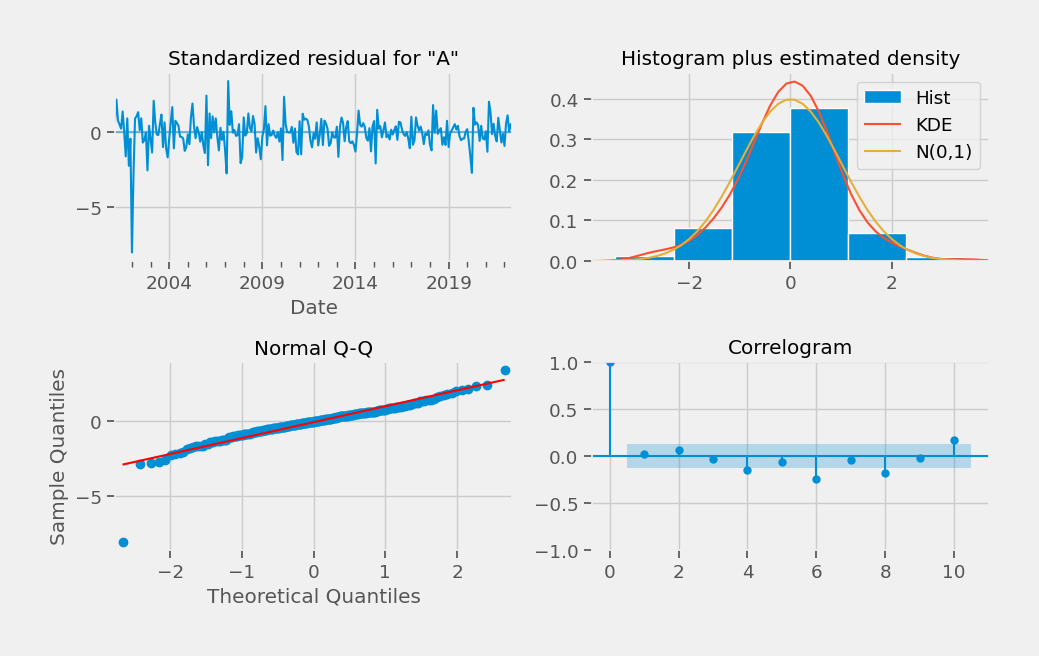

In [ ]:
# Obtain diagnostic plots
fig = sarima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

almost the same
-  Normal Q-Q Plot  the points  strlitly sround the line  the residuals are not normally distributed, which can affect the validity of the model's predictions.
- There are significant lags in the correlogram of residuals-it indicates our model has missed something.
- Standardized Residuals Over Time is not constant  there is a variance( magnitude of a peak befor 2004)

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,522.609
- MSE = 2,825,905.161
- RMSE = 1,681.043
- R^2 = -1.281
- MAPE = 6.94%


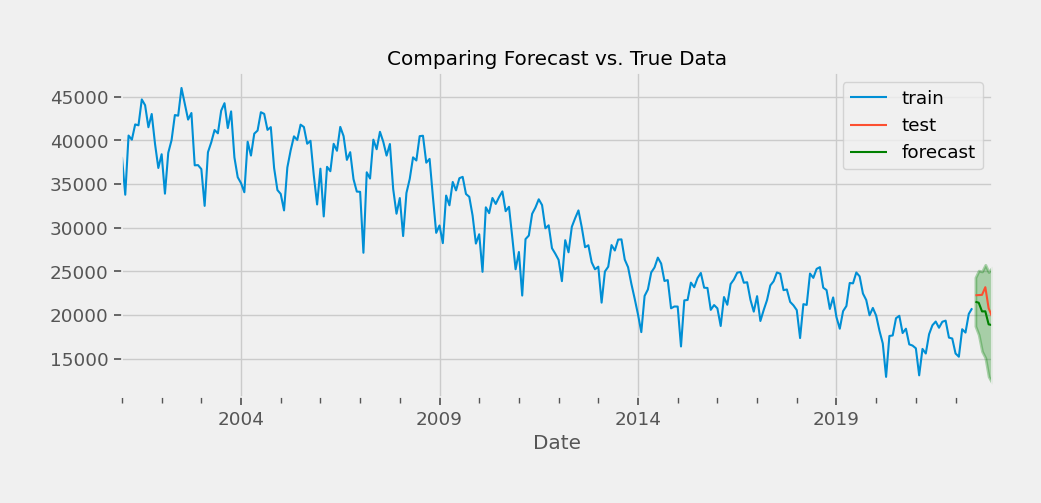

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df1 = sarima_model1.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df1);
# Obtain metrics
regression_metrics_ts(test, forecast_df1['mean'])

#This model is worst than the first model
- R2 is negtive
- MAPE is larger = 6.9% and is was 5.3%
- slightly improvment in AIC = 4513.55


#**Auto_Arima**

In [ ]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True
)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.93 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4756.537, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4590.361, Time=1.35 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4647.189, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4754.725, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4738.449, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4567.983, Time=1.44 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4521.312, Time=2.66 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4513.684, Time=2.47 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4642.213, Time=1.46 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=4589.044, Time=4.88 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=4615.124, Time=1.32 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.11 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4525.443, Time=1.06 sec
 ARIMA(2,1,0)(1,0,1)[12] inte

# the best( pdqPDQm )from Auto_Arima
pdqPDQm = (1,1,0,1,0,1,12)

In [ ]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1# nonseasonal differencing
q = 0 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima_model2= tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         All Crimes   No. Observations:                  258
Model:             ARIMA(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -2253.198
Date:                            Wed, 18 Sep 2024   AIC                           4514.397
Time:                                    21:32:13   BIC                           4528.593
Sample:                                01-01-2001   HQIC                          4520.106
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1691      0.034     -4.999      0.000      -0.235      -0.103
ar.S.L12       0.9397      0.013     72.460      0.000       0.914       0.965
ma.S.L12      -0.7682      0.027    -28.336      0.000      -0.821      -0.715
sigma2       2.01e+06   3.46e-10   5.82e+15      0.000    2.01e+06    2.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):               178.75
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+31. Standard errors may be unstable.
"""

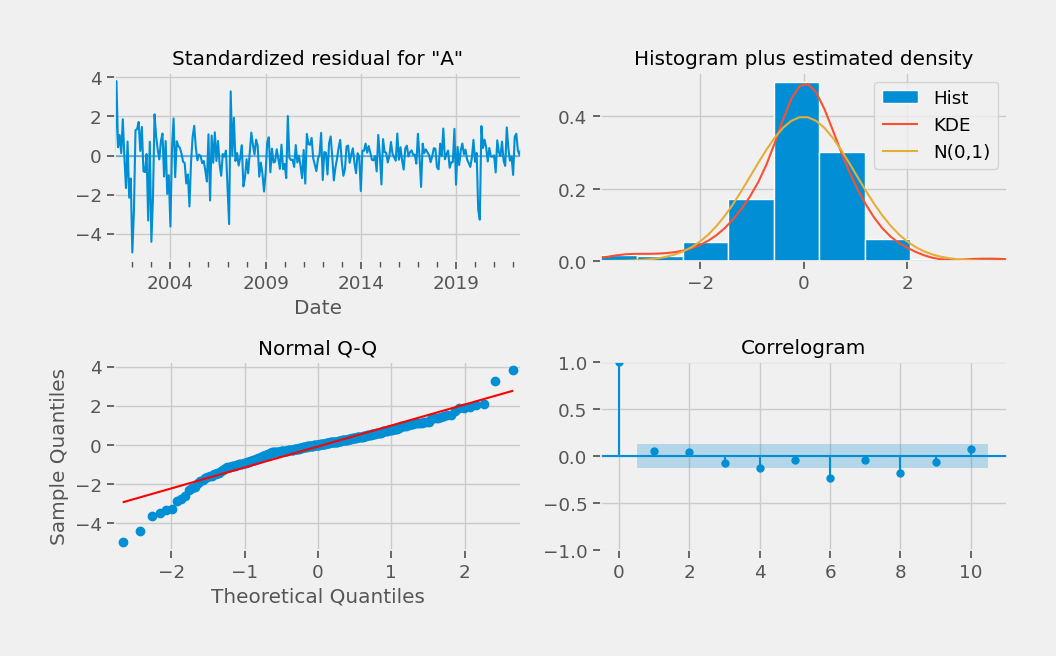

In [ ]:
# Obtain diagnostic plots
fig = sarima_model2.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()


- In the Normal Q-Q Plot, the points are mostly around the line, but the tails deviate significantly, indicating that the residuals are not normally distributed. This can affect the validity of the model's predictions.
- There are still significant lags in the correlogram of residuals, suggesting that our model has overlooked some important aspects.
- The standardized residuals over time are not constant; there is notable variance, particularly with larger peaks in earlier years.

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,572.374
- MSE = 2,998,538.340
- RMSE = 1,731.629
- R^2 = -1.421
- MAPE = 7.18%


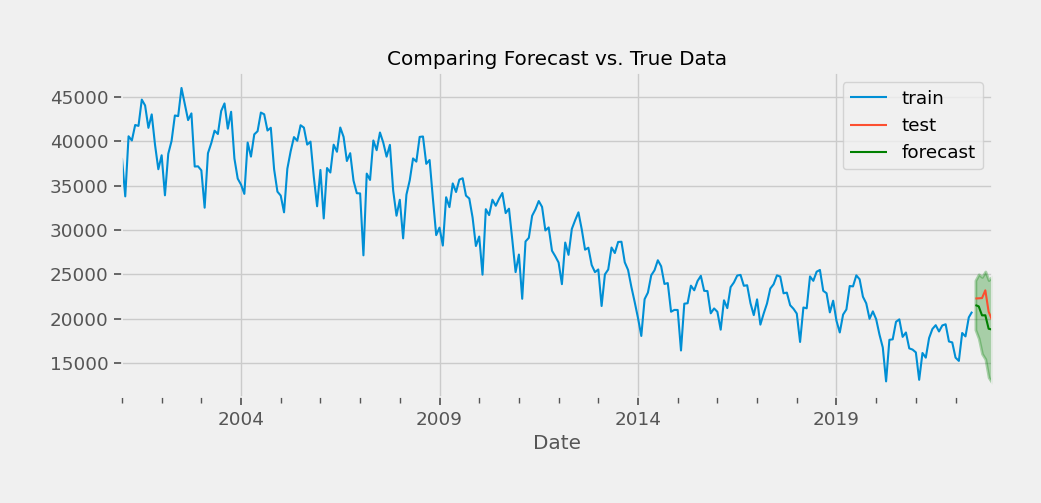

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df2 = sarima_model2.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df2);
# Obtain metrics
regression_metrics_ts(test, forecast_df2['mean'])

#This model is getting  worst than the two befor
- R2 is negtive
- MAPE is larger = 7.10%
- slightly improvment in AIC = 4514


In [ ]:
print("\n","\033[1mComparing models with the same d value\033[0m")
print(f"sarima_model order {(sarima_model.model.order,sarima_model.model.seasonal_order)} {regression_metrics_ts(test, forecast_df['mean'])}")
print(f"sarima_model AIC = {sarima_model.aic.round(2)},\n ")

print(f"sarima_model1 order {(sarima_model1.model.order,sarima_model1.model.seasonal_order)} {regression_metrics_ts(test, forecast_df1['mean'])}")
print(f"sarima_model1 AIC = {sarima_model1.aic.round(2)},\n ")

print(f"sarima_model2 order {(sarima_model2.model.order,sarima_model2.model.seasonal_order)} {regression_metrics_ts(test, forecast_df2['mean'])}")
print(f"sarima_model2 AIC = {sarima_model2.aic.round(2)},\n ")


 Comparing models with the same d value
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,184.870
- MSE = 1,801,172.036
- RMSE = 1,342.078
- R^2 = -0.454
- MAPE = 5.31%
sarima_model order ((1, 1, 1), (1, 0, 0, 12)) None
sarima_model AIC = 4587.25,
 
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,522.609
- MSE = 2,825,905.161
- RMSE = 1,681.043
- R^2 = -1.281
- MAPE = 6.94%
sarima_model1 order ((0, 1, 2), (1, 0, 1, 12)) None
sarima_model1 AIC = 4513.1,
 
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,572.374
- MSE = 2,998,538.340
- RMSE = 1,731.629
- R^2 = -1.421
- MAPE = 7.18%
sarima_model2 order ((1, 1, 0), (1, 0, 1, 12)) None
sarima_model2 AIC = 4514.4,
 


# The first model is the best of the worst  MAPE= 5%  but the AIC is greater

#Make true future forecasts using the entire dataset (for dates beyond the entire ts).

In [ ]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1# nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

final_model= tsa.ARIMA(ts, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()



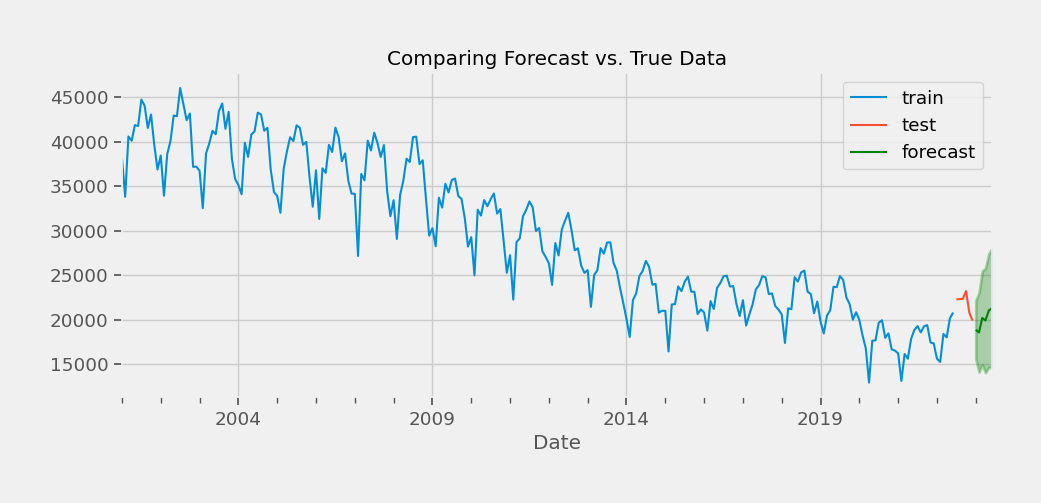

In [ ]:
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [ ]:
starting_value = forecast_df['mean'].iloc[0]
starting_value

18841.81534198785

In [ ]:
# the predicted for 6 months into the future
final_value = forecast_df['mean'].iloc[-1]
final_value


21287.899447564672

In [ ]:
change = final_value - starting_value
change

2446.0841055768215

In [ ]:
#calculate this as a percentage by dividing the delta by the starting value.
perc_change = (change / starting_value) * 100
perc_change



12.982210371873618

In [ ]:
print(f'The allocated period is from {forecast_df.index[0].strftime("%Y-%m-%d")} to {forecast_df.index[-1].strftime("%Y-%m-%d")}.\n')
print(f"The total crime count over the 6 months is {forecast_df['mean'].sum().round(2)} crimes.\n")
print(f"The percent change in crime count at the end of the 6 months is an increase of {perc_change.round(2)}%")

The allocated period is from 2023-01-01 to 2023-06-01.

The total crime count over the 6 months is 119752.02 crimes.

The percent change in crime count at the end of the 6 months is an increase of 12.98%


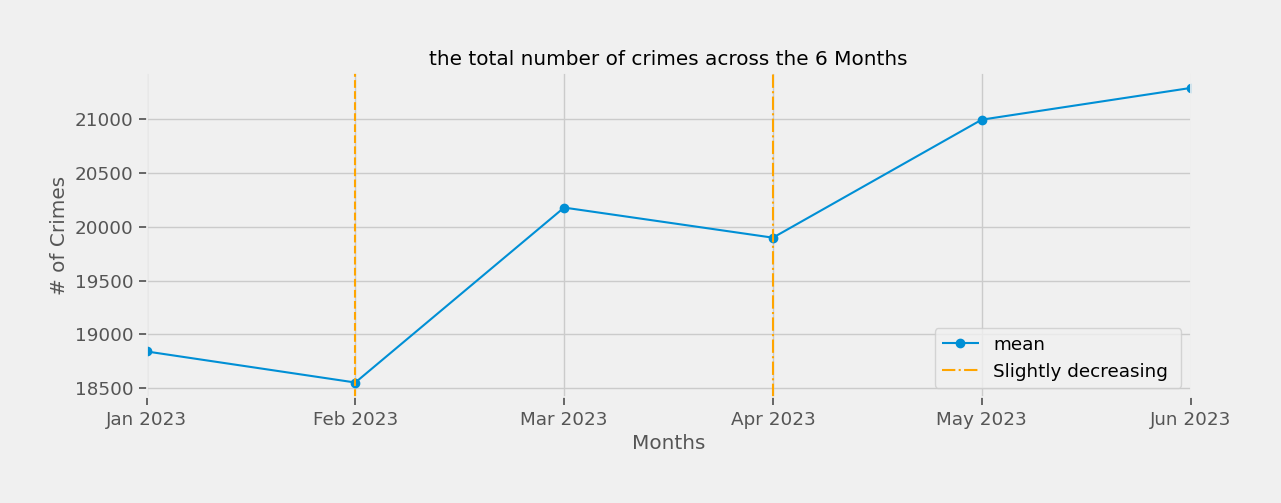

In [ ]:
ax=forecast_df['mean'].plot(style='o-',grid=True,ylabel='# of Crimes', xlabel='Months',title="the total number of crimes across the 6 Months",
                    figsize=(12,4),xticks=forecast_df['mean'].index);
ax.set_xticklabels( [x.strftime('%b %Y') for x in forecast_df['mean'].index], rotation=0)
ax.axvline('2023-02-01', color='orange',ls='--')
ax.axvline('2023-04-01', color='orange',ls='-.',label='Slightly decreasing ')
ax.legend()
fig.tight_layout()
fig.savefig('SavedPlot.png', dpi = 300)




#Summarizing the Forecast
## The allocated period is from 2023-01-01 to 2023-06-01.

##The total crime count over the 6 months is 119752.02 crimes.

##The percent change in crime count at the end of the 6 months is an increase of 12.98%